In [222]:
# tratamiento de los datos
# ============================================
import pandas as pd
import numpy as np
from scipy.stats import skew
import scipy.stats as st
import sidetable
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import kurtosistest
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor

# librerías para la visualización de los datos
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer tamaño fijo de gráficas
# ==================================
plt.rcParams["figure.figsize"] = (10,8)

# Configuración warnings
# ======================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pingouin

In [ ]:
!pip install lazypredict

# Objectives
Description of data, identification of variables to be taken into account for the calculation of health insurance premiums.



---

In [86]:
df = pd.read_csv("../data/00-insurance.csv", index_col = 0).reset_index()
df.head(2)

age     sex    bmi  children smoker     region     charges
0   19  female  27.90         0    yes  southwest  16884.9240
1   18    male  33.77         1     no  southeast   1725.5523

## Understand the variables we have and what our dataframe looks like.

In [9]:
# number of rows and columns in the dataframe

df.shape

(1338, 7)

In [10]:
# general data frame information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [11]:
# name of the columns of our dataframe

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

### Statistics

In [12]:
# leading statistics of the numeric columns.

df.describe().T

count          mean           std        min         25%       50%  \
age       1338.0     39.207025     14.049960    18.0000    27.00000    39.000   
bmi       1338.0     30.663397      6.098187    15.9600    26.29625    30.400   
children  1338.0      1.094918      1.205493     0.0000     0.00000     1.000   
charges   1338.0  13270.422265  12110.011237  1121.8739  4740.28715  9382.033   

                   75%          max  
age          51.000000     64.00000  
bmi          34.693750     53.13000  
children      2.000000      5.00000  
charges   16639.912515  63770.42801

In [175]:
df.charges.median()

9382.033

In [13]:
# main statistics of the categorical variables

df.describe(include ="object").T

count unique        top  freq
sex     1338      2       male   676
smoker  1338      2         no  1064
region  1338      4  southeast   364

Data integrity:
- Smoking habits, majority non-smokers (274 smokers)
- BMI mean 30, overweight (more than 75% over BMI 25)

---

## Null

In [14]:
df.isnull().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

---

## Duplicates

In [15]:
# duplicados 

df.duplicated().sum()

1

In [16]:
df[df.duplicated()== True] 

age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df.duplicated().sum()

0

---

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


---

# Outliers

In [229]:
numericas = df.select_dtypes(include=np.number)
numericas.head(2)

age    bmi  children     charges
0   19  27.90         0  16884.9240
1   18  33.77         1   1725.5523

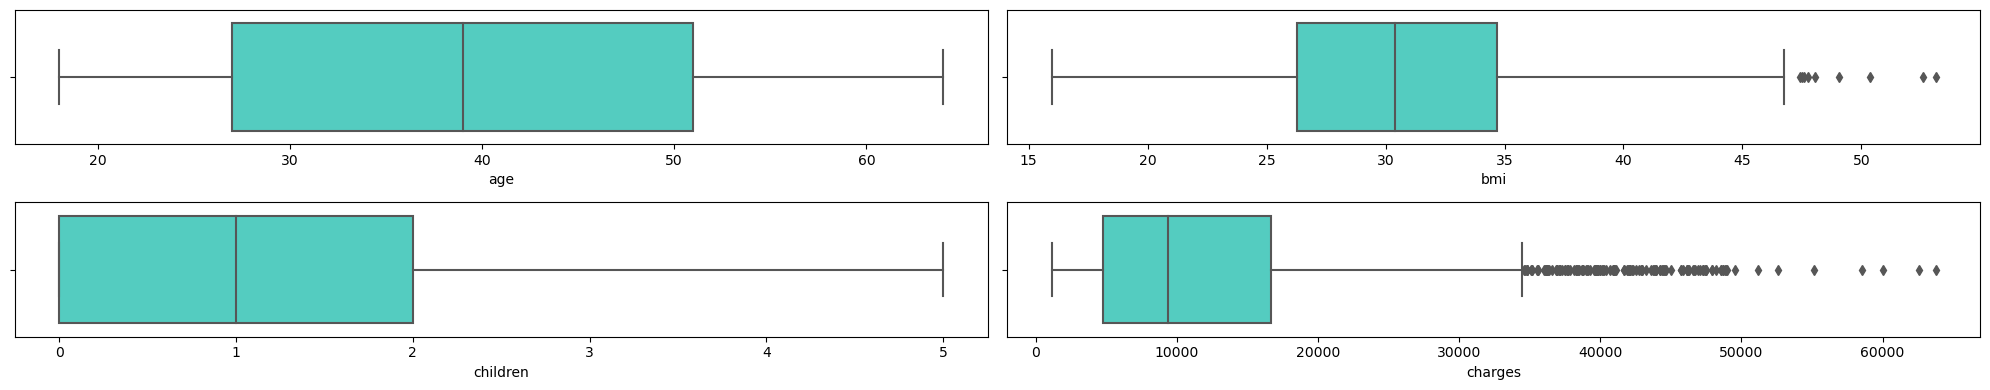

In [77]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax=axes[indice], color = "turquoise") 
plt.tight_layout()
plt.show();

In the boxplots we see a lot of outliers, we see the distributions to decide the treatment, I am not going to do anything with them yet, before I see if I unfold the dataset or not.

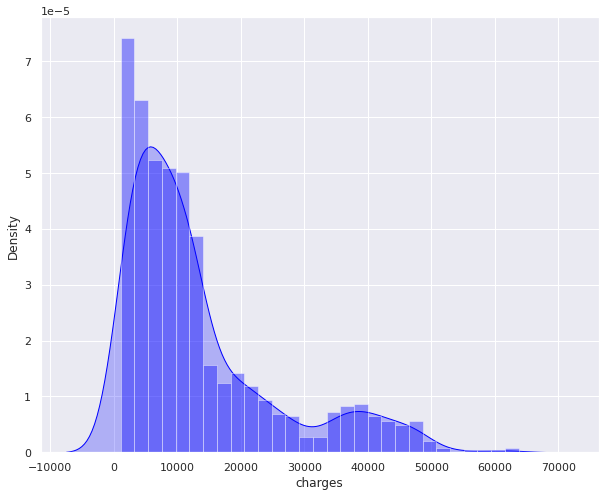

In [108]:
# I'm going to look at the distribution of variable charges
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df["charges"], 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});


Not normal 

## We analyse the numerical variables of the dataset

### Distributions

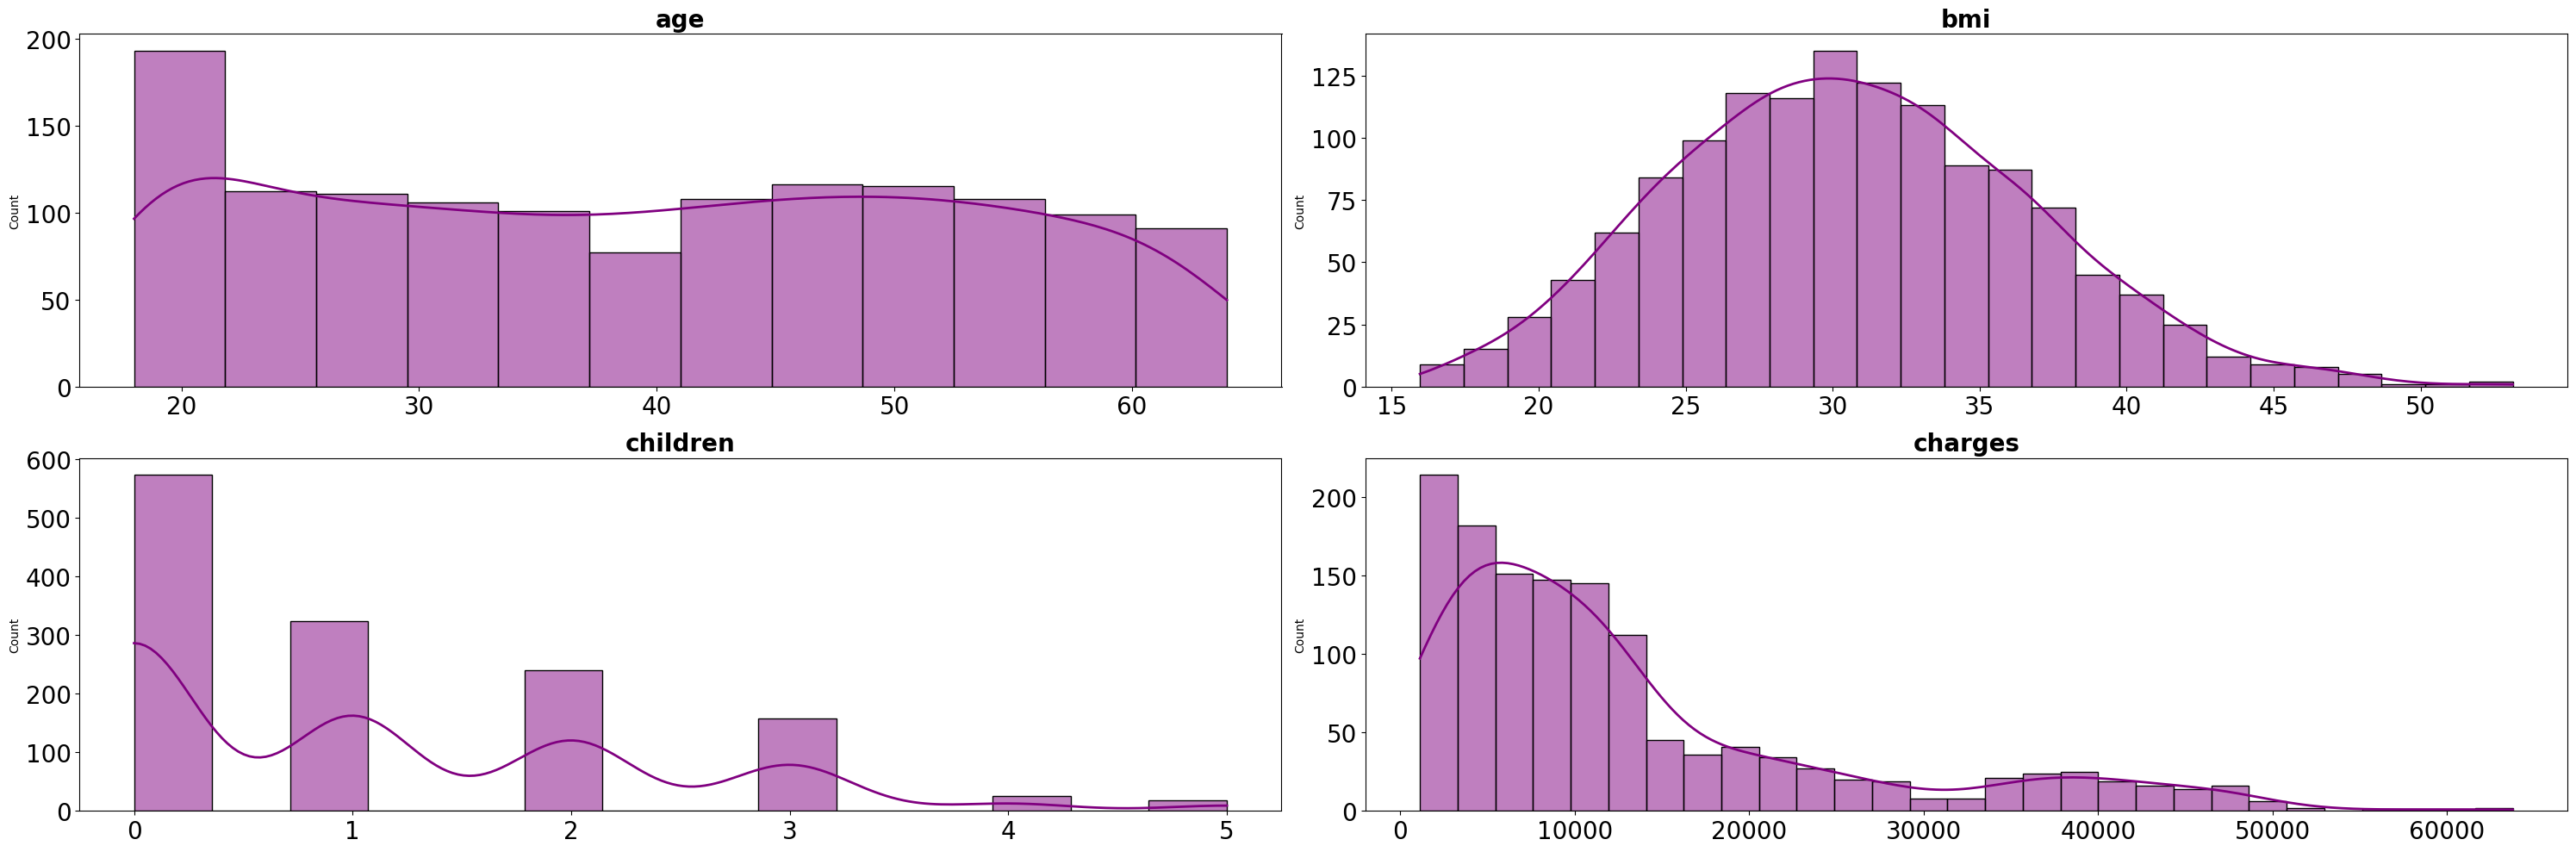

In [78]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterator
for i, colum in enumerate(numericas.columns): 
    sns.histplot(
        data = numericas[colum],
        kde = True,
        color = "purple", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5, 
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

### Relationship to the response variable

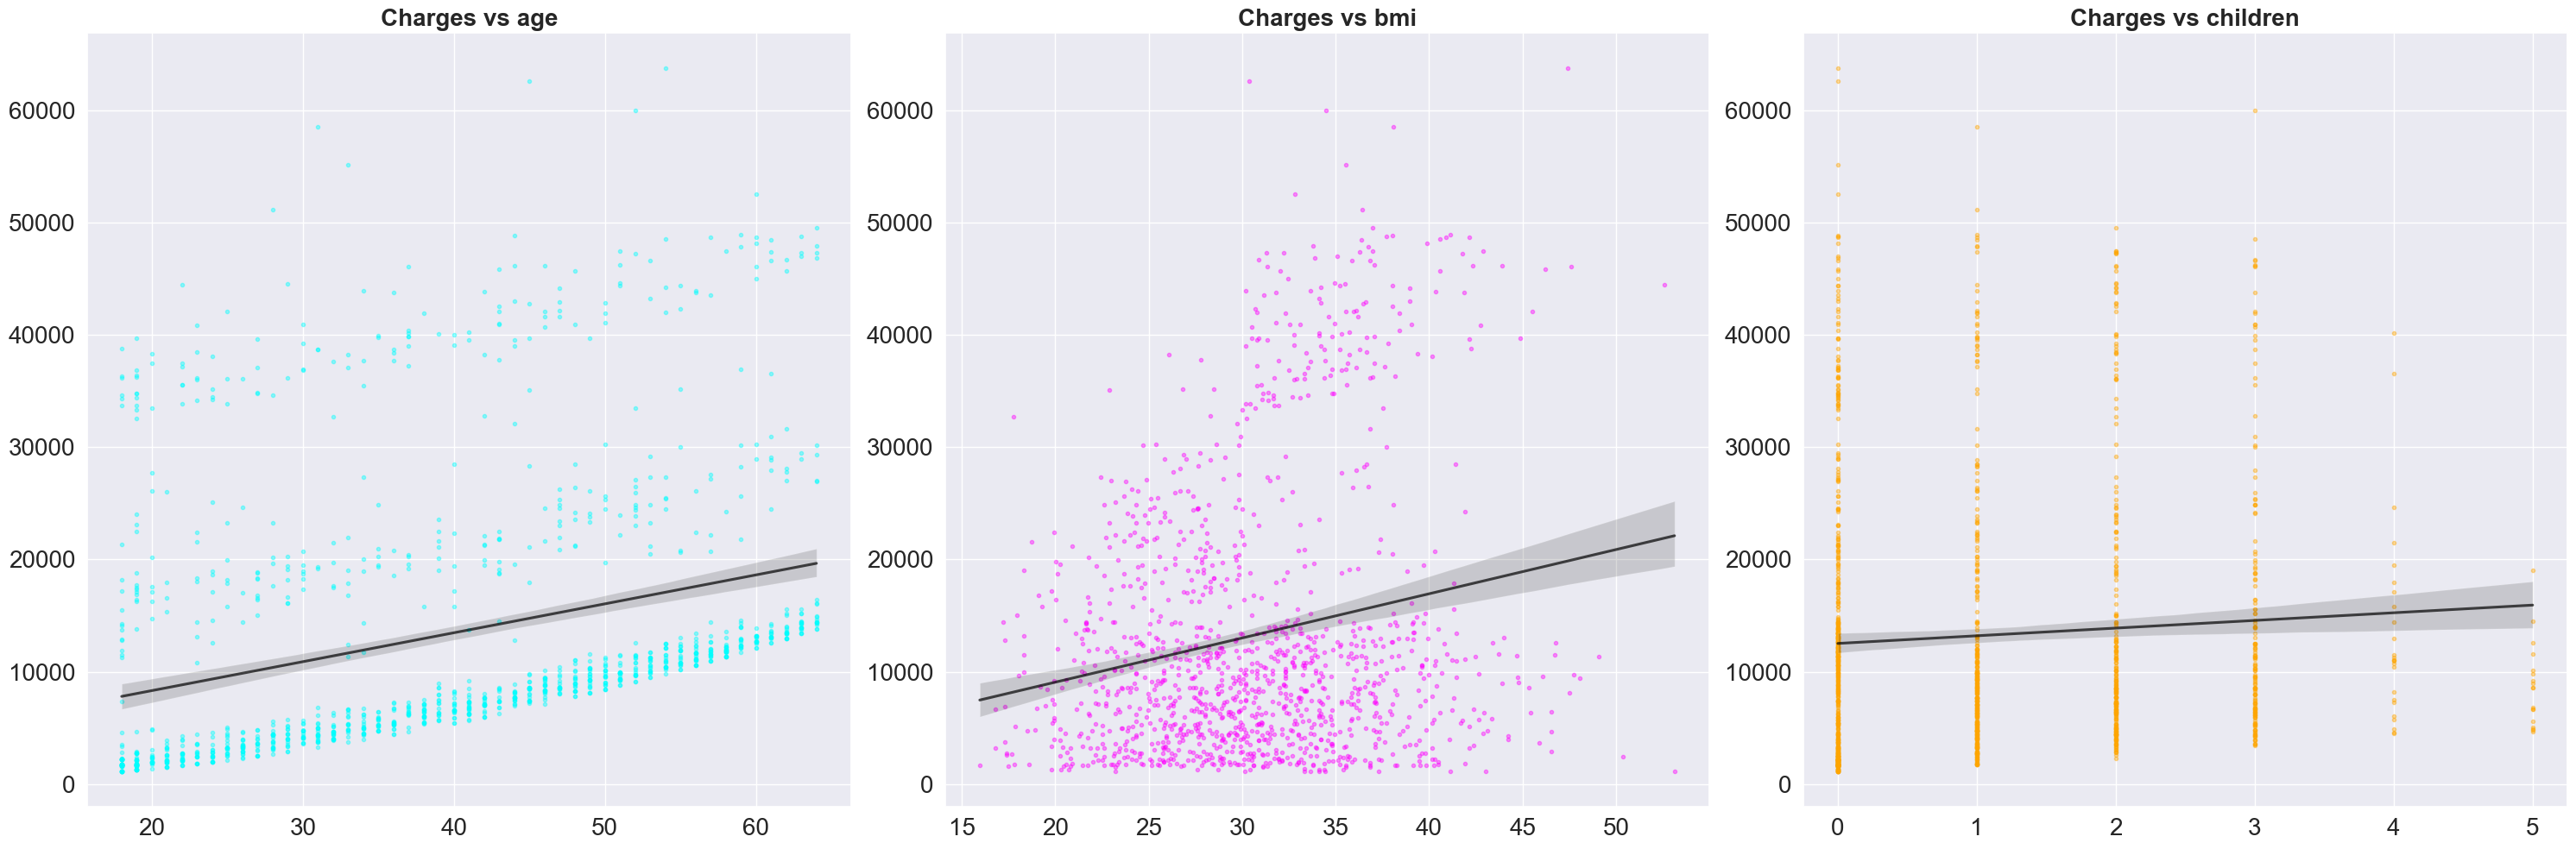

In [174]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
lista_colores = ["cyan", "magenta", "orange"]

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("charges")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["charges"], 
        color = lista_colores[i], 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Charges vs {colum}", fontsize = 20, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();


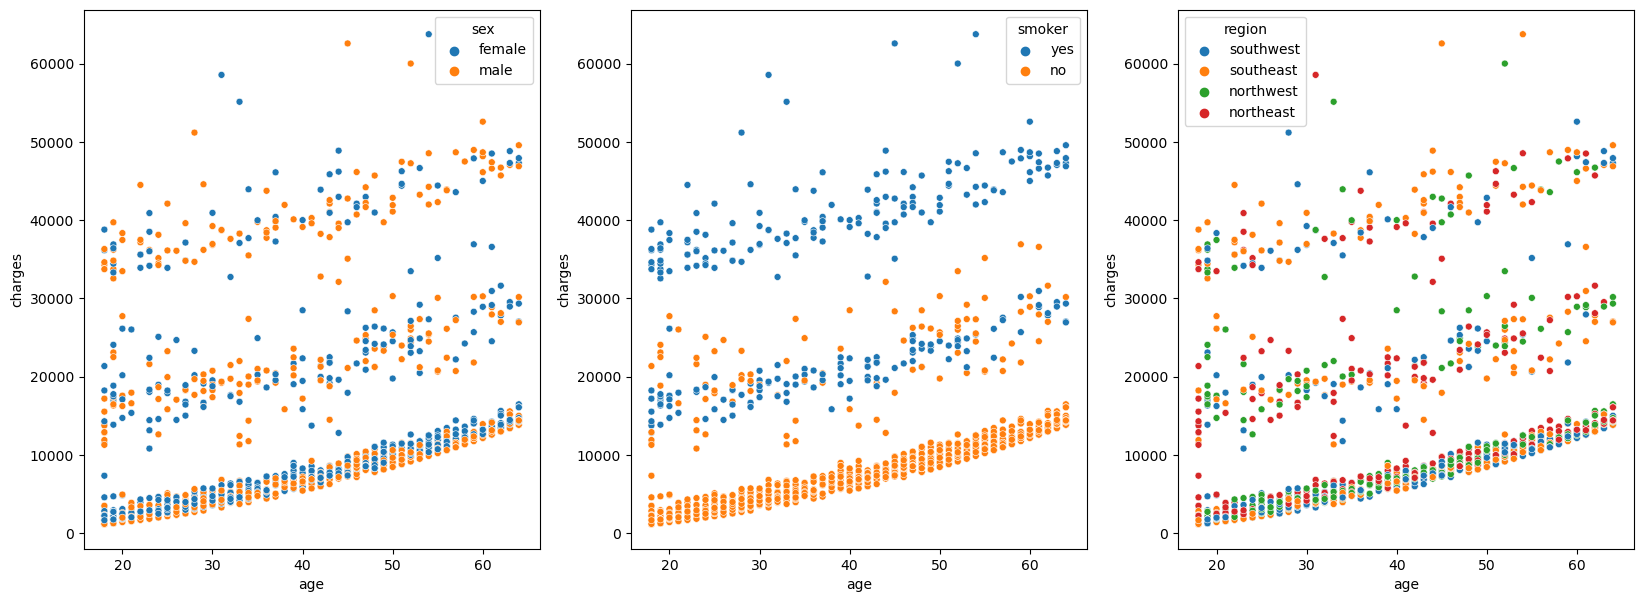

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='age', y='charges', data = df,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

Here we see that in age, there are about three clear trend lines in the distribution of our data.  
**-------------------------------------All 3 increase with age and tobacco-------------------------------------**

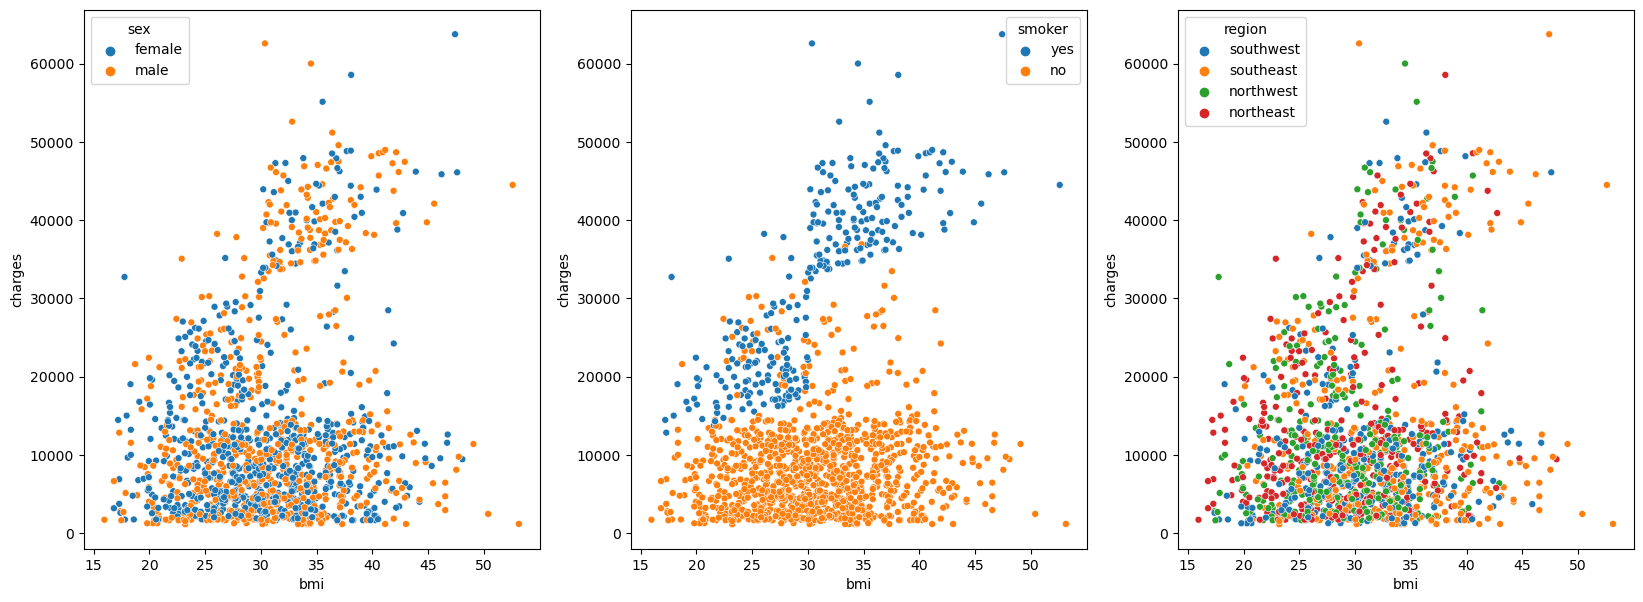

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))

for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='bmi', y='charges', data = df,
                    s = 25,    
                    hue = categoricas.columns[i], 
                    ax=axes[i])  
plt.show(); 

**-------------------------------We see that there is a clear increase  in charges with tobacco--------------------------**

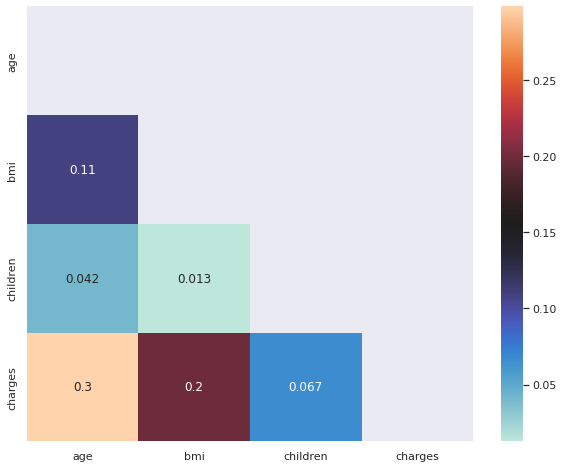

In [111]:
mask = np.triu(np.ones_like(df.corr(), dtype = np.bool))
sns.heatmap(df.corr(method='spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

### Apparently, the most correlated is age.

## Categorical variables

### I create some graphs to go deeper into the data

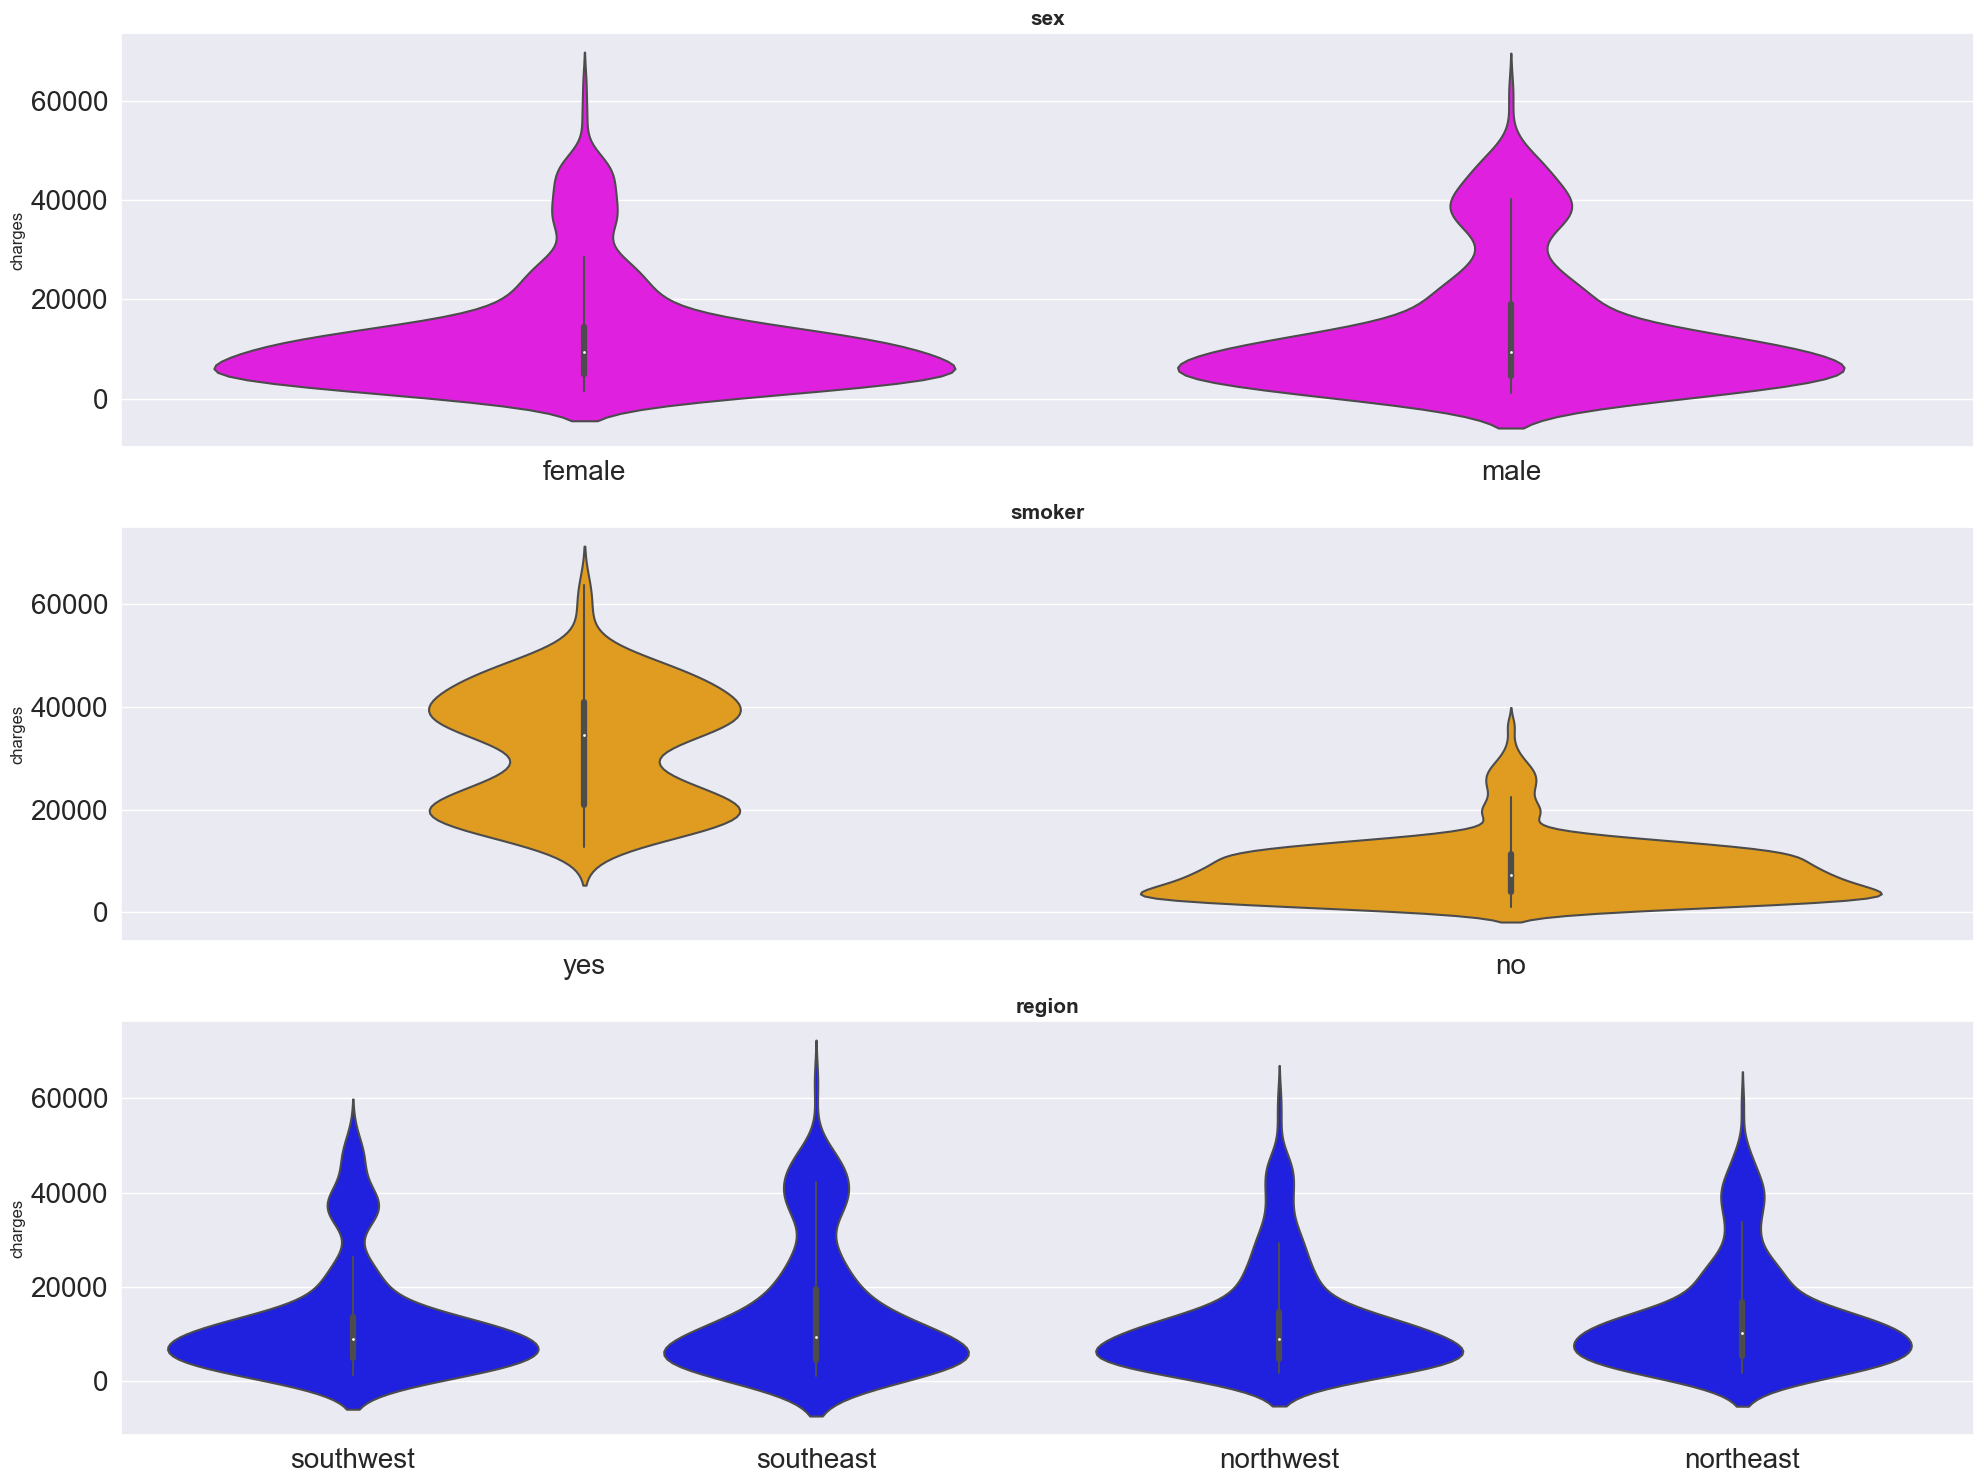

In [228]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
axes = axes.flat
lista_colores = [ "magenta", "orange","blue", "green"]
columnas = df.select_dtypes(include = 'object')
columnas = columnas.columns
for i, colum in enumerate(columnas): 
    sns.violinplot(
        data = df,
        x = colum,
        y = 'charges',
        color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")

fig.tight_layout();

### Region

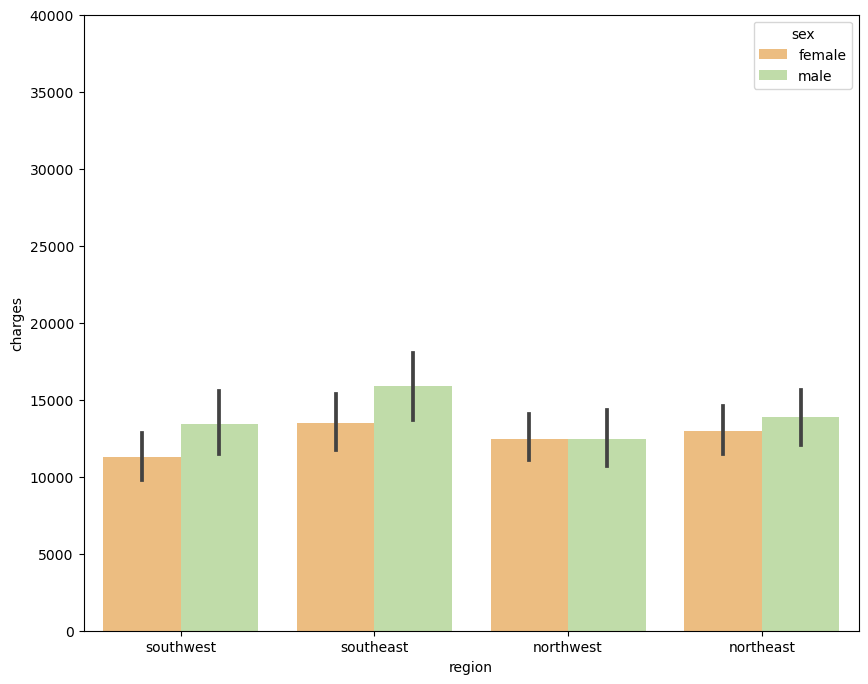

In [59]:
sns.barplot(x='region', y='charges', hue='sex', data=df, palette='Spectral')
plt.ylim(0,40000);

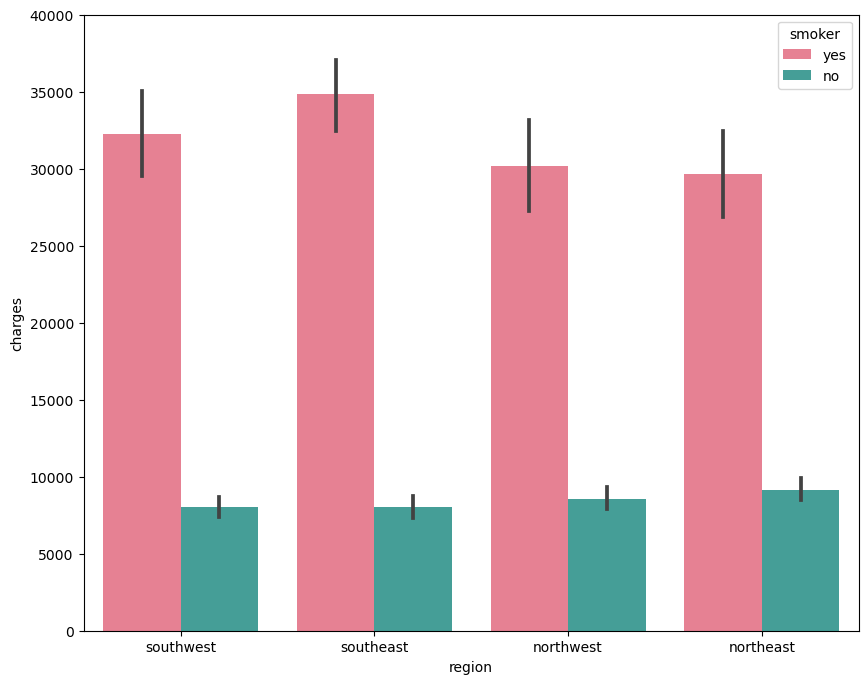

In [60]:
sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=df, palette='husl')
plt.ylim(0,40000);

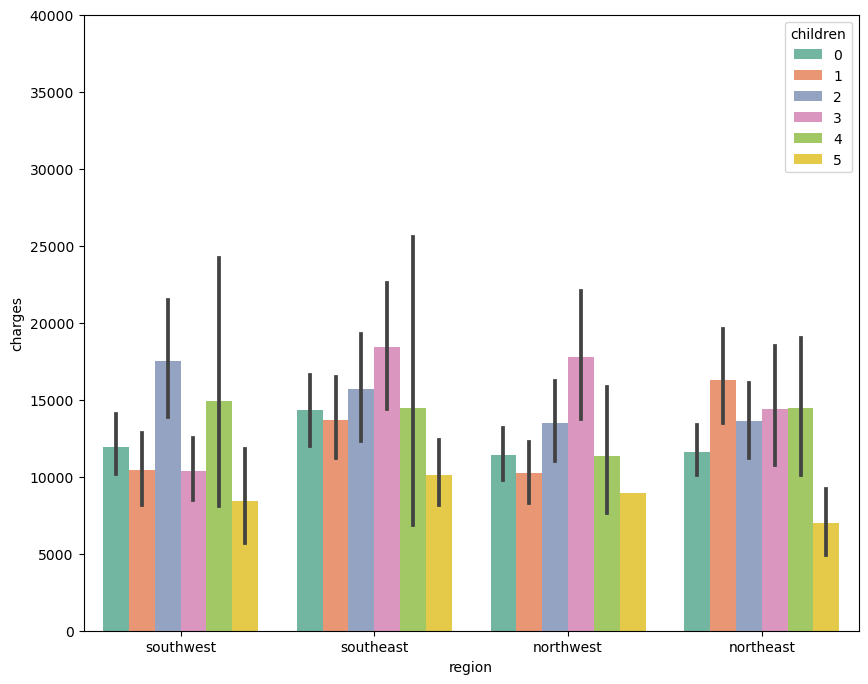

In [61]:
sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set2')
plt.ylim(0,40000);

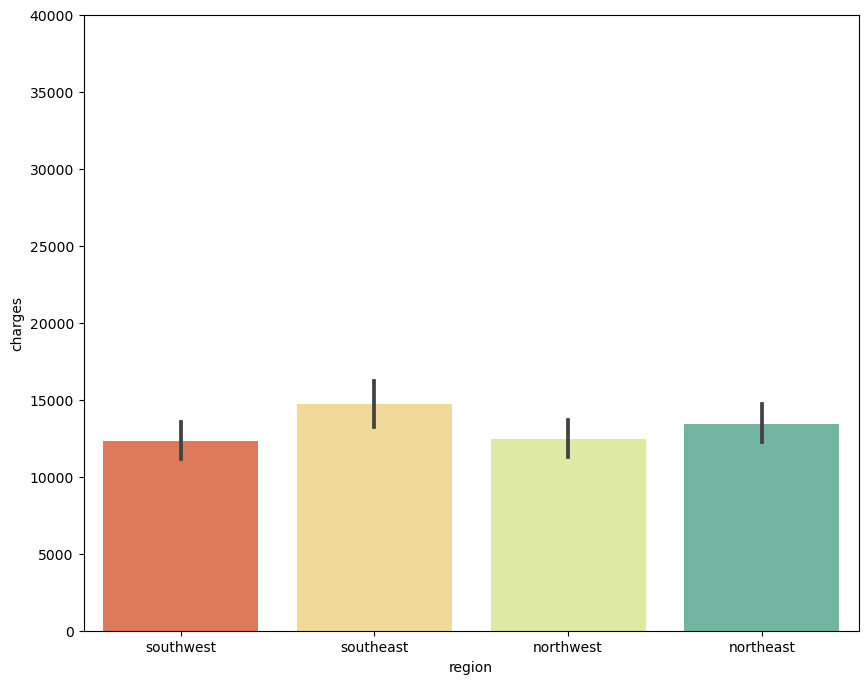

In [62]:
sns.barplot(x='region', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

We see that there is a certain relationship between region and premiums, but it is not very pronounced and we do not see too much logic in the relationship at the moment, we already see differences in smoking habits.

---

### Children

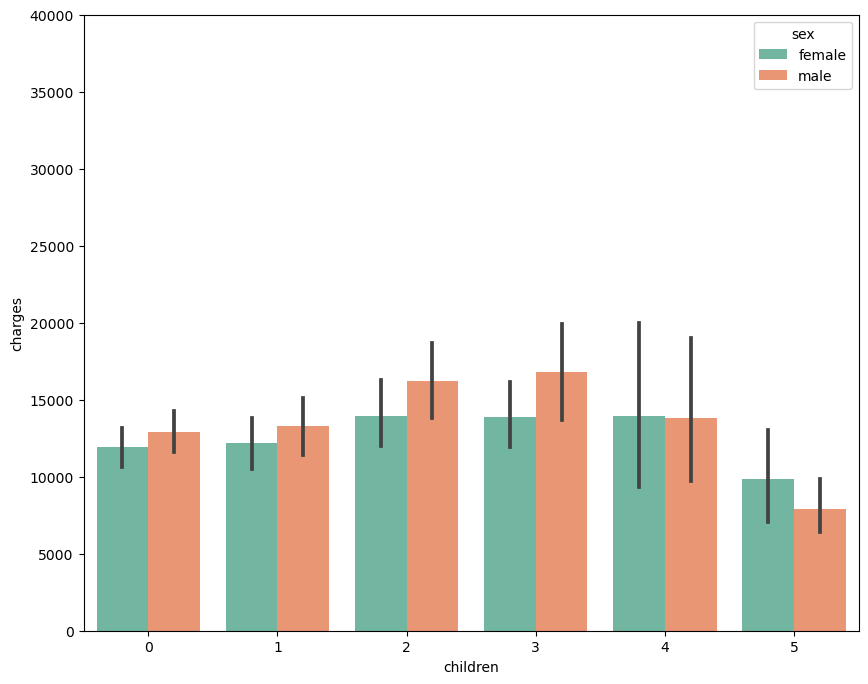

In [63]:
sns.barplot(x='children', y='charges', hue='sex', data=df, palette='Set2')
plt.ylim(0,40000);

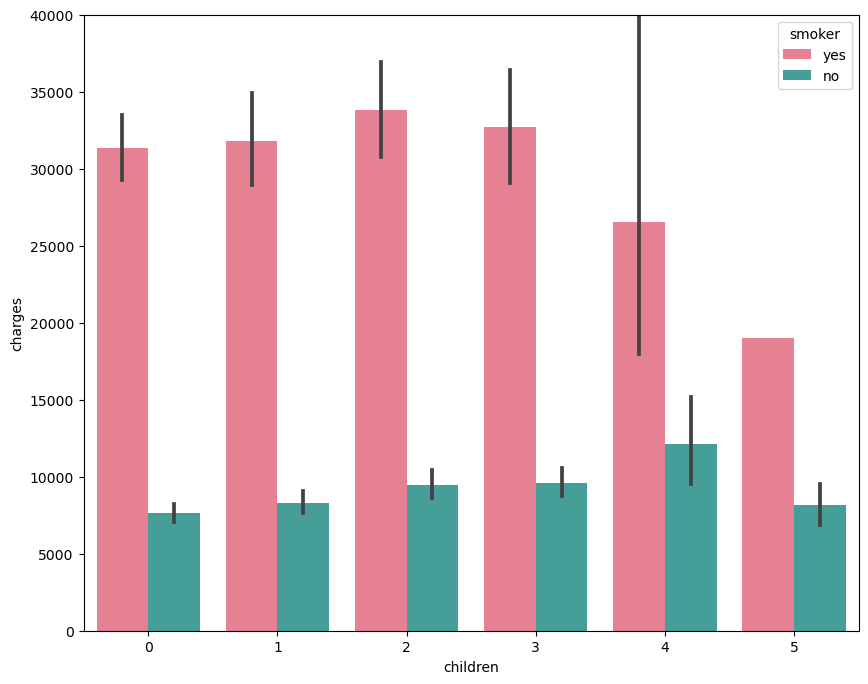

In [64]:
sns.barplot(x = 'children', y = 'charges',
                 hue='smoker', data=df, palette='husl')
plt.ylim(0,40000);

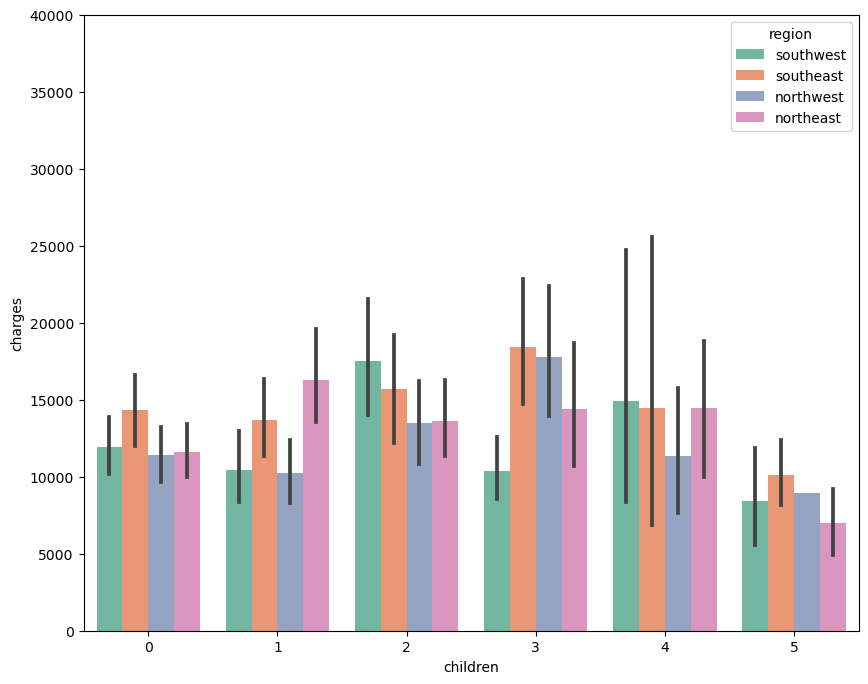

In [65]:
sns.barplot(x='children', y='charges', hue='region', data=df, palette='Set2')
plt.ylim(0,40000);

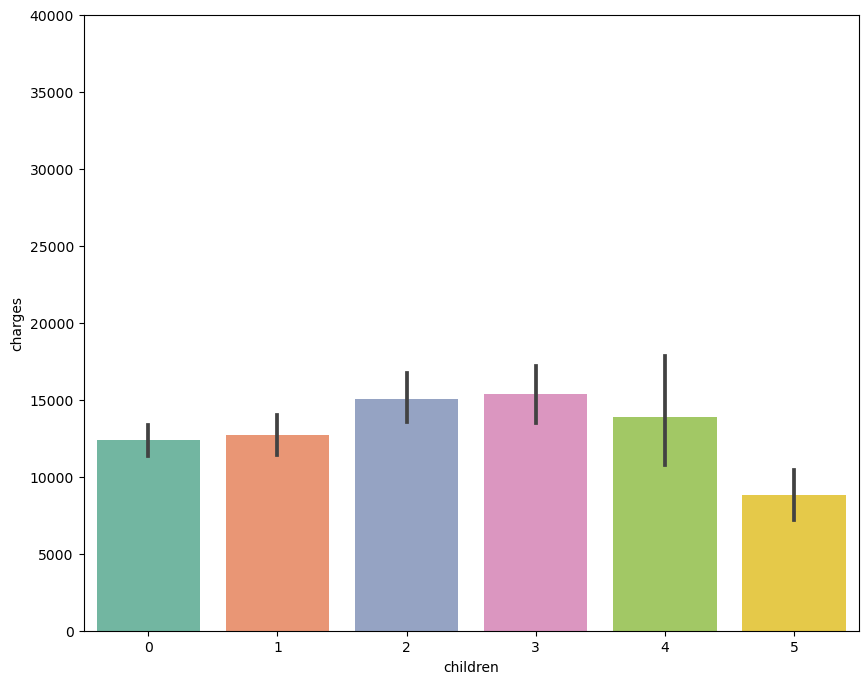

In [66]:
sns.barplot(x='children', y='charges', data=df, palette='Set2')
plt.ylim(0,40000);

We can see that the premiums from 0 to 3 dependents are in increasing order of premiums, but from 3 onwards, they start to decrease, and the relationship is not clear either.

---

### Smoker

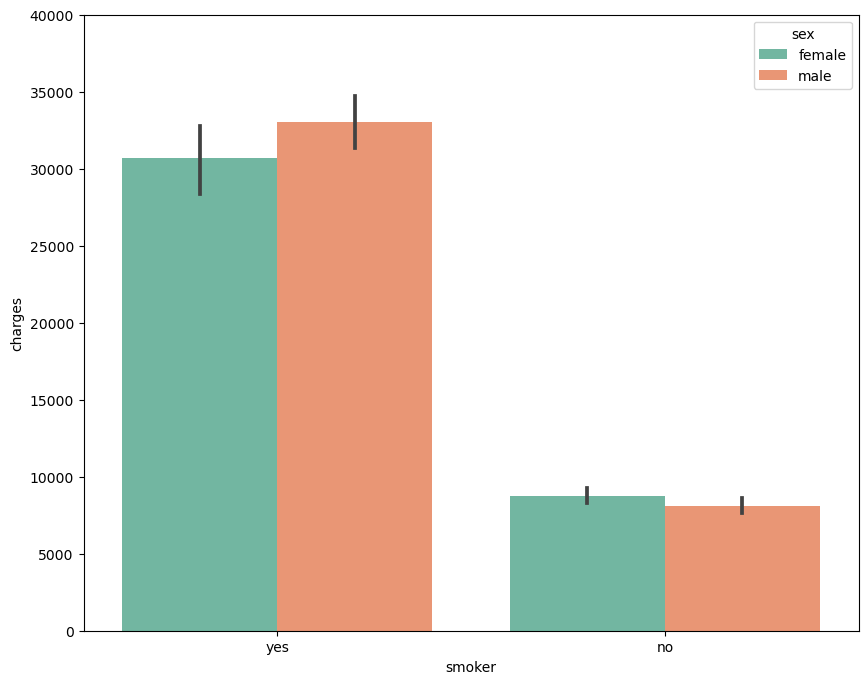

In [67]:
sns.barplot(x='smoker', y='charges', hue='sex', data=df, palette='Set2')
plt.ylim(0,40000);

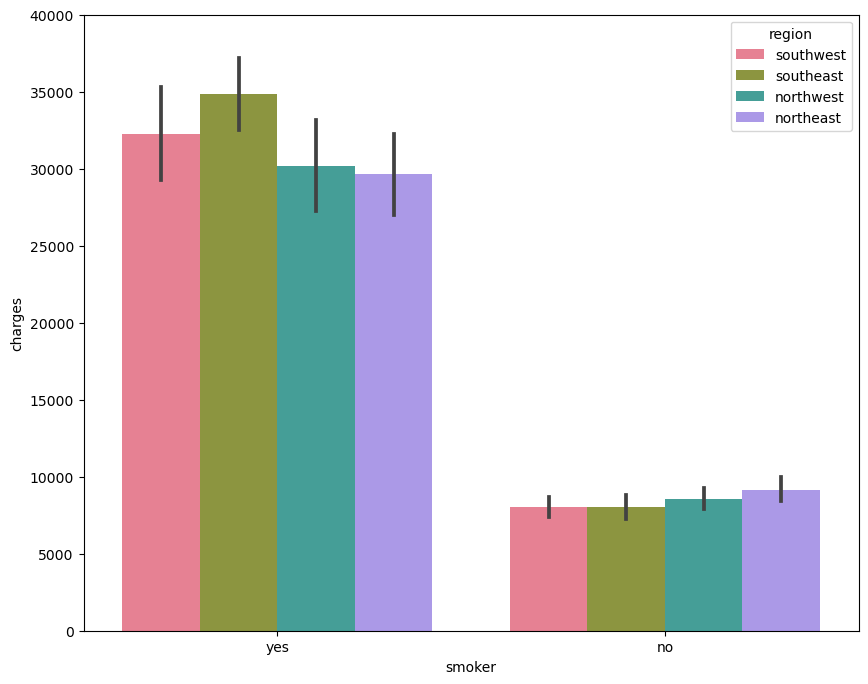

In [68]:
sns.barplot(x = 'smoker', y = 'charges',
                 hue='region', data=df, palette='husl')
plt.ylim(0,40000);

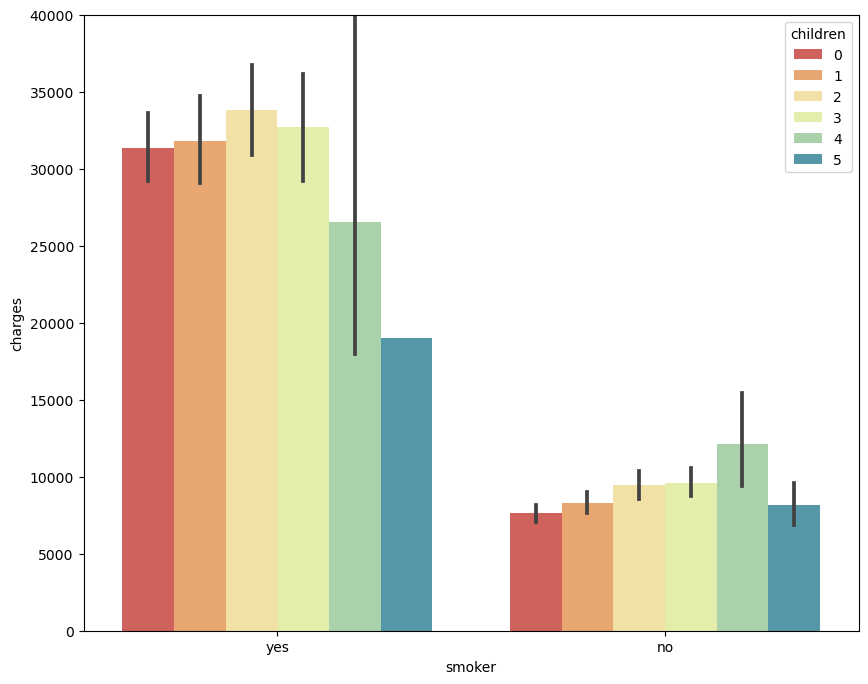

In [69]:
sns.barplot(x='smoker', y='charges', hue='children', data=df, palette='Spectral')
plt.ylim(0,40000);

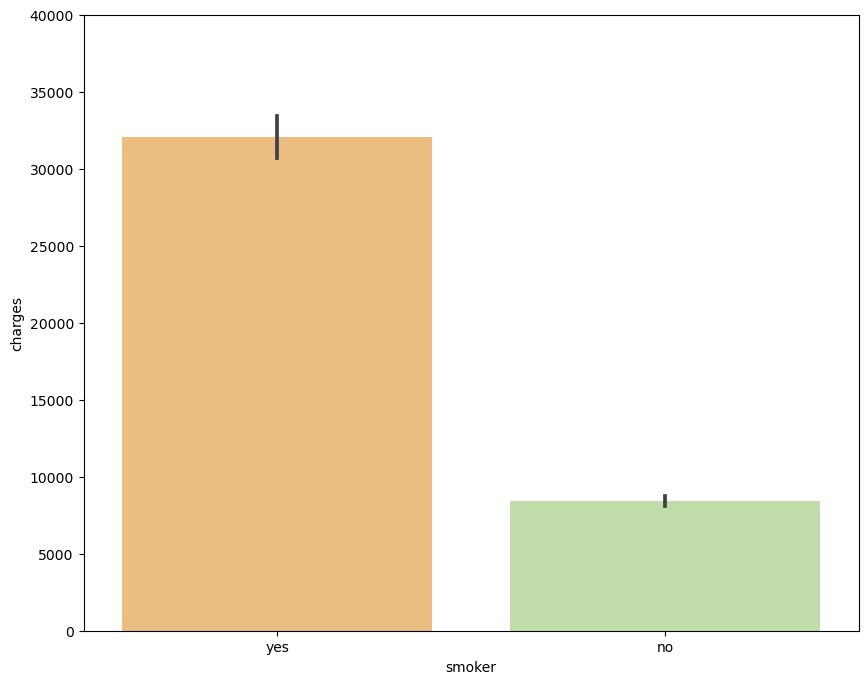

In [70]:
sns.barplot(x='smoker', y='charges', data=df, palette='Spectral')
plt.ylim(0,40000);

We see a fairly clear relationship with smoking habits and the amount of premiums.

### Sex

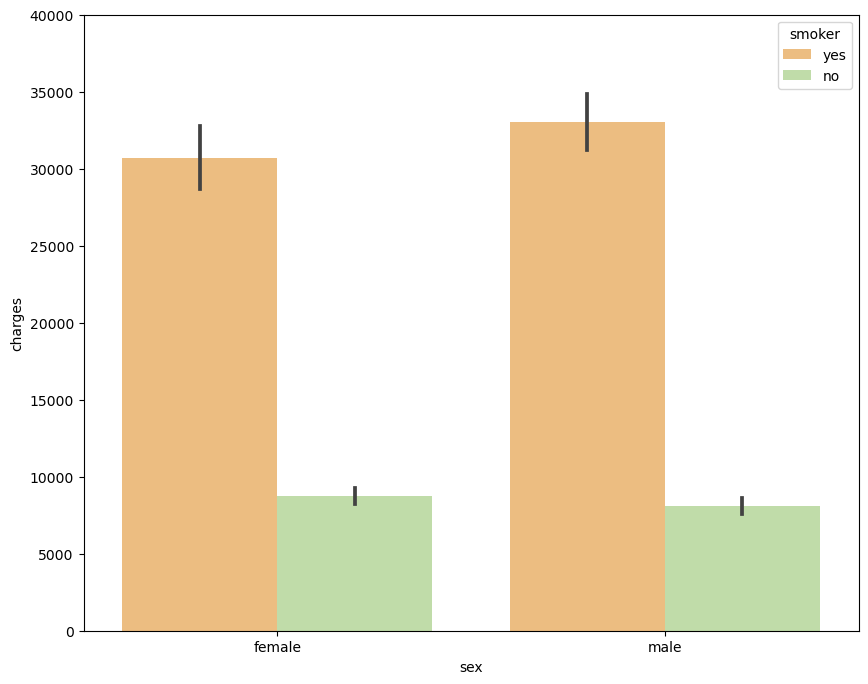

In [71]:
sns.barplot(x='sex', y='charges',hue='smoker' ,data=df, palette='Spectral')
plt.ylim(0,40000);


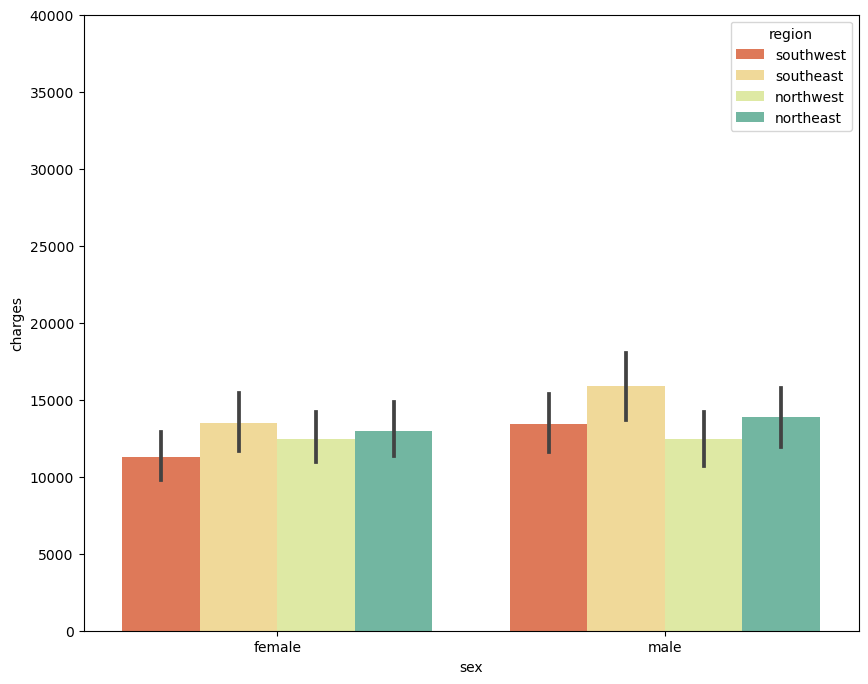

In [80]:
sns.barplot(x='sex', y='charges',hue='region', data=df, palette='Spectral')
plt.ylim(0,40000);

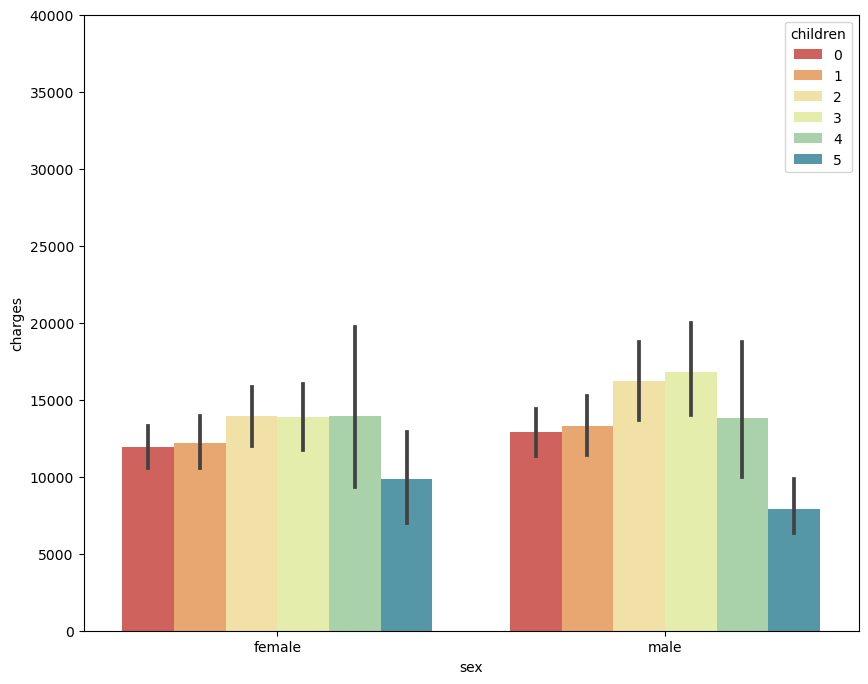

In [81]:
sns.barplot(x='sex', y='charges',hue='children' ,data=df, palette='Spectral')
plt.ylim(0,40000);

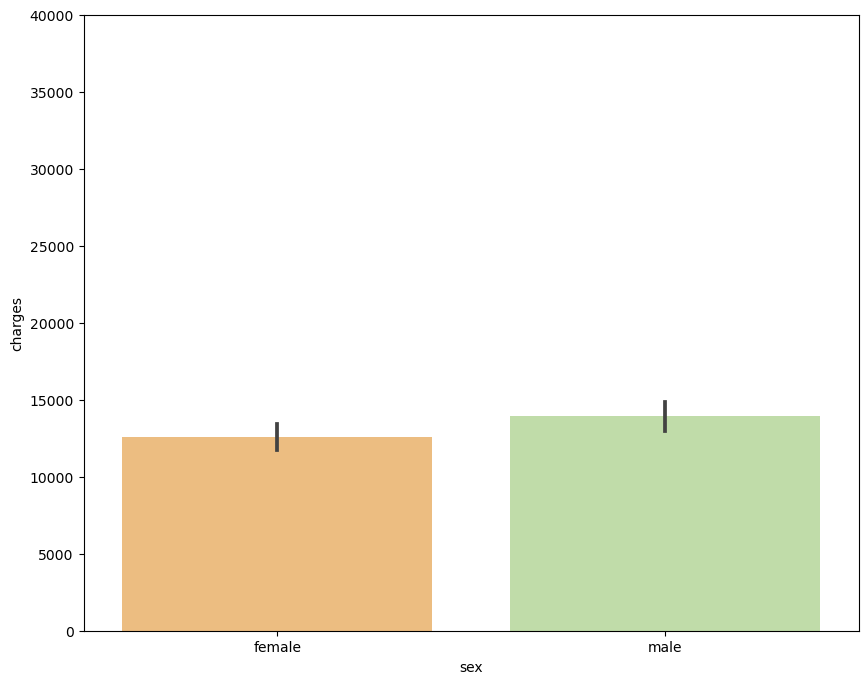

In [82]:
sns.barplot(x='sex', y='charges' ,data=df, palette='Spectral')
plt.ylim(0,40000);

Slight variation by region, but clear variation by smoking status

---

BMI <25

In [21]:
df_peso=df[df['bmi']<25]

In [23]:
df.shape

(1337, 7)

In [22]:
df_peso.shape #son un total de 245 registros sin sobrepeso

(245, 7)

<Axes: xlabel='bmi', ylabel='Count'>

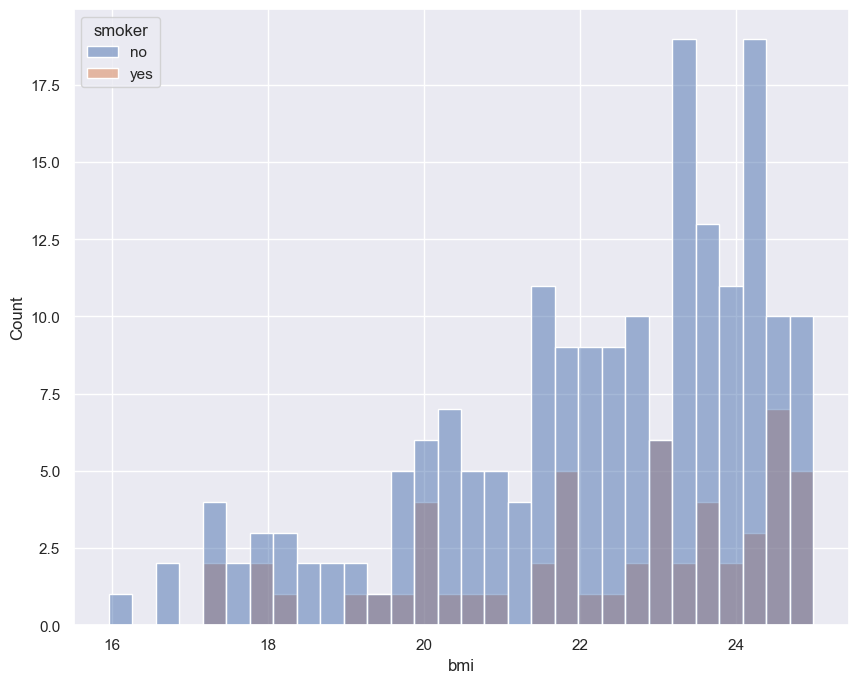

In [214]:
sns.histplot(data =df_peso, x = "bmi", hue = "smoker",bins=30); 

In [26]:
df_peso.describe(include='all')#190 smoking registrations and 75% have charges up to 14572, 
#would almost all be in the low charges group.

age     sex         bmi    children smoker     region  \
count   245.000000     245  245.000000  245.000000    245        245   
unique         NaN       2         NaN         NaN      2          4   
top            NaN  female         NaN         NaN     no  northeast   
freq           NaN     129         NaN         NaN    190         83   
mean     36.375510     NaN   22.203898    1.122449    NaN        NaN   
std      13.606811     NaN    2.103806    1.238598    NaN        NaN   
min      18.000000     NaN   15.960000    0.000000    NaN        NaN   
25%      24.000000     NaN   20.800000    0.000000    NaN        NaN   
50%      35.000000     NaN   22.705000    1.000000    NaN        NaN   
75%      47.000000     NaN   23.900000    2.000000    NaN        NaN   
max      64.000000     NaN   24.985000    5.000000    NaN        NaN   

             charges  
count     245.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    10282.224474  
std      7520.485850  
min      1121.873900  
25%      3861.209650  
50%      8582.302300  
75%     14571.890800  
max     35069.374520

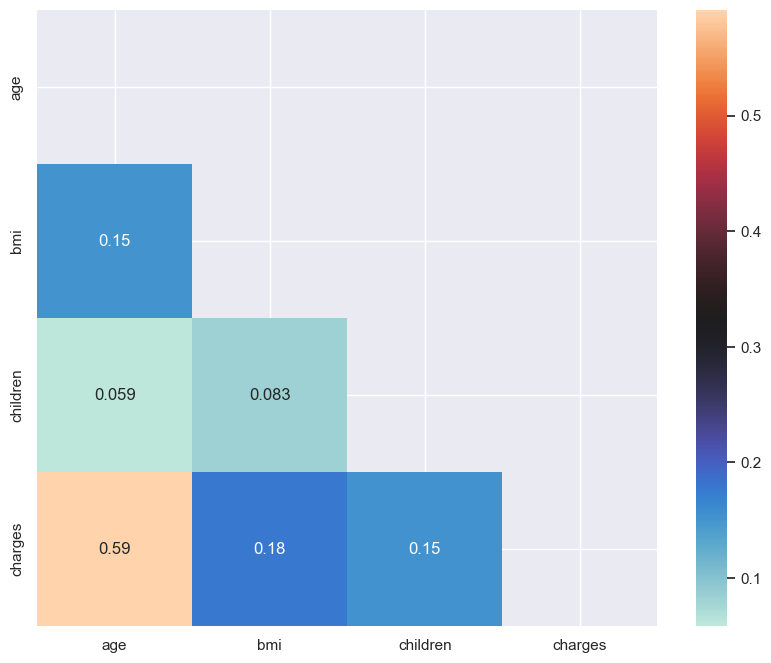

In [217]:
mask = np.triu(np.ones_like(df_peso.corr(), dtype = np.bool))
sns.heatmap(df_peso.corr(method='spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

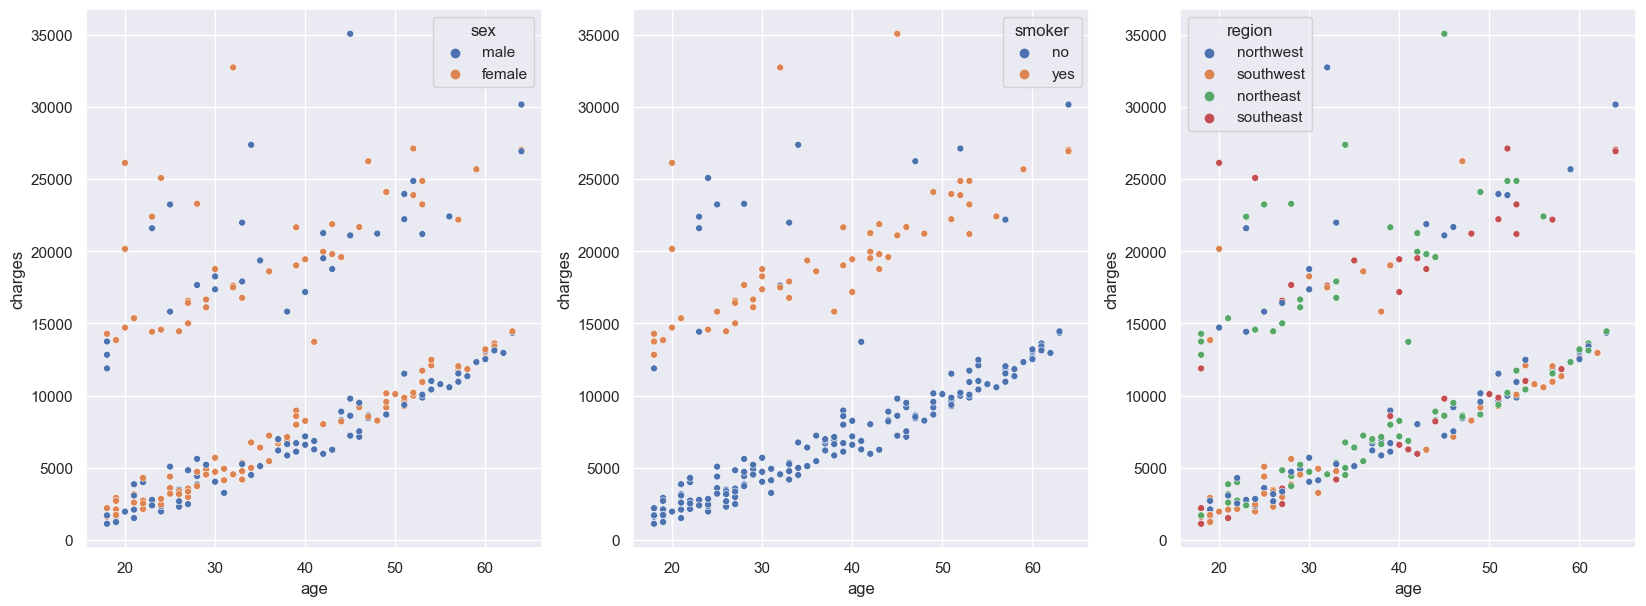

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='age', y='charges', data = df_peso,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

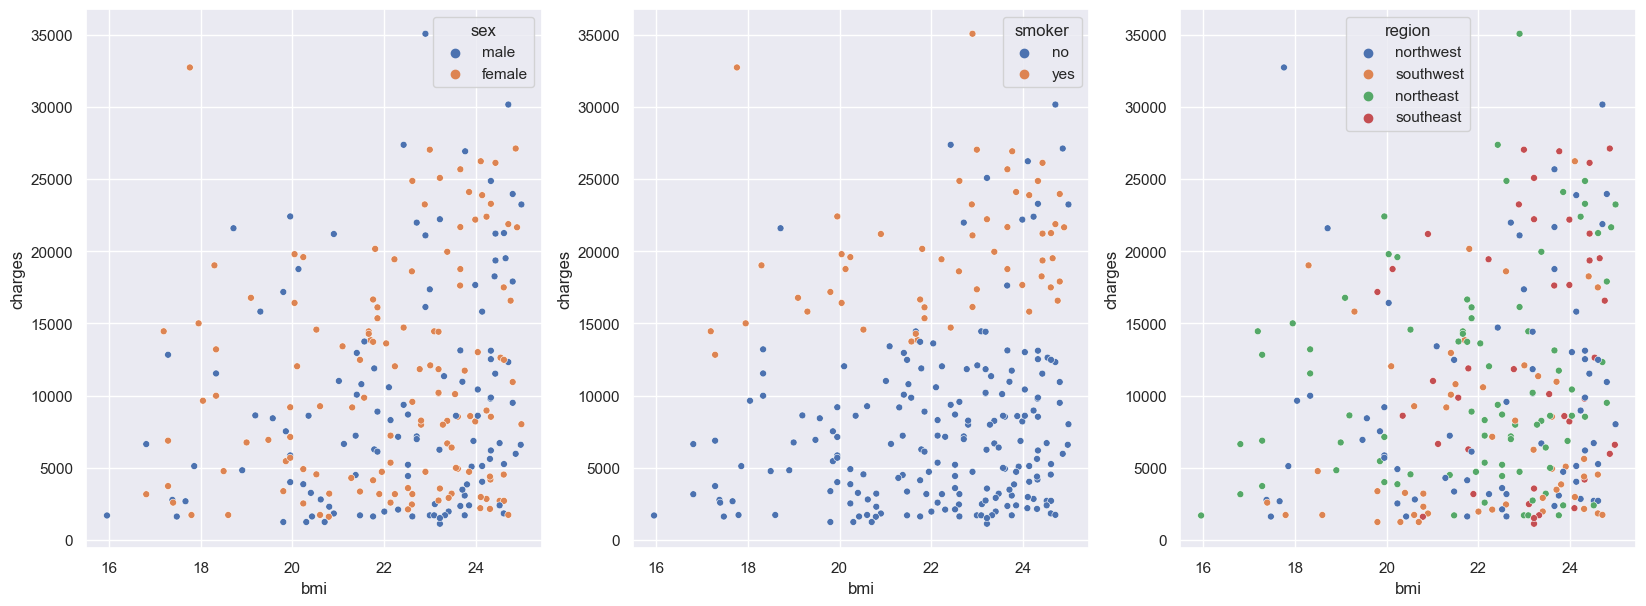

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='bmi', y='charges', data = df_peso,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

### In the case of healthy BMI, there is a clear tendency to increase with age, and at the same time, we see that it also depends on the smoking habit, clearly they are higher when smoked at all ages. We have lost the highest band of charges, so we assume that the unhealthy BMI factor conditions that band.

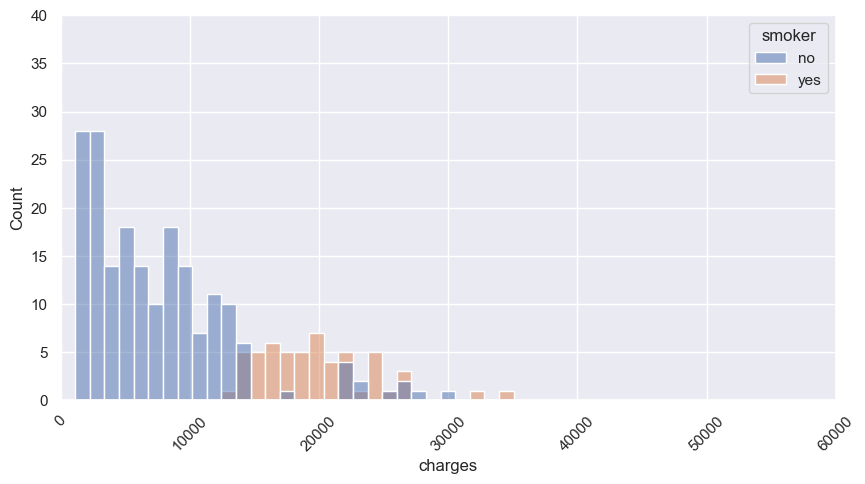

In [216]:
plt.figure(figsize = (10,5)) 
sns.histplot(data =df_peso, x = "charges", hue = "smoker",bins=30) 
plt.ylim(0,40)
plt.xlim(0,60000)
plt.xticks(rotation = 45);

In [36]:
df_peso_fumador=df_peso[(df_peso['smoker']=='yes')]

In [37]:
df_peso_fumador.describe(include='all')

age     sex        bmi   children smoker     region  \
count   55.000000      55  55.000000  55.000000     55         55   
unique        NaN       2        NaN        NaN      1          4   
top           NaN  female        NaN        NaN    yes  northeast   
freq          NaN      32        NaN        NaN     55         22   
mean    37.309091     NaN  22.277182   1.236364    NaN        NaN   
std     12.480908     NaN   2.182447   1.261446    NaN        NaN   
min     18.000000     NaN  17.195000   0.000000    NaN        NaN   
25%     27.500000     NaN  20.710000   0.000000    NaN        NaN   
50%     38.000000     NaN  22.895000   1.000000    NaN        NaN   
75%     45.500000     NaN  24.130000   2.000000    NaN        NaN   
max     64.000000     NaN  24.890000   5.000000    NaN        NaN   

             charges  
count      55.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    19839.278309  
std      4583.245438  
min     12829.455100  
25%     16499.137025  
50%     19361.998800  
75%     22049.467450  
max     35069.374520

BMI > 25

In [100]:
df_peso2=df[df['bmi']>25]

In [101]:
df_peso2.describe(include='all')

age   sex          bmi     children smoker     region  \
count   1091.000000  1091  1091.000000  1091.000000   1091       1091   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   560          NaN          NaN    872        323   
mean      39.817599   NaN    32.573483     1.089826    NaN        NaN   
std       14.071792   NaN     4.982788     1.199081    NaN        NaN   
min       18.000000   NaN    25.080000     0.000000    NaN        NaN   
25%       27.000000   NaN    28.600000     0.000000    NaN        NaN   
50%       40.000000   NaN    31.900000     1.000000    NaN        NaN   
75%       52.000000   NaN    35.815000     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1091.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    13946.476035  
std     12834.725537  
min      1131.506600  
25%      4889.518150  
50%      9563.029000  
75%     17654.442975  
max     63770.428010

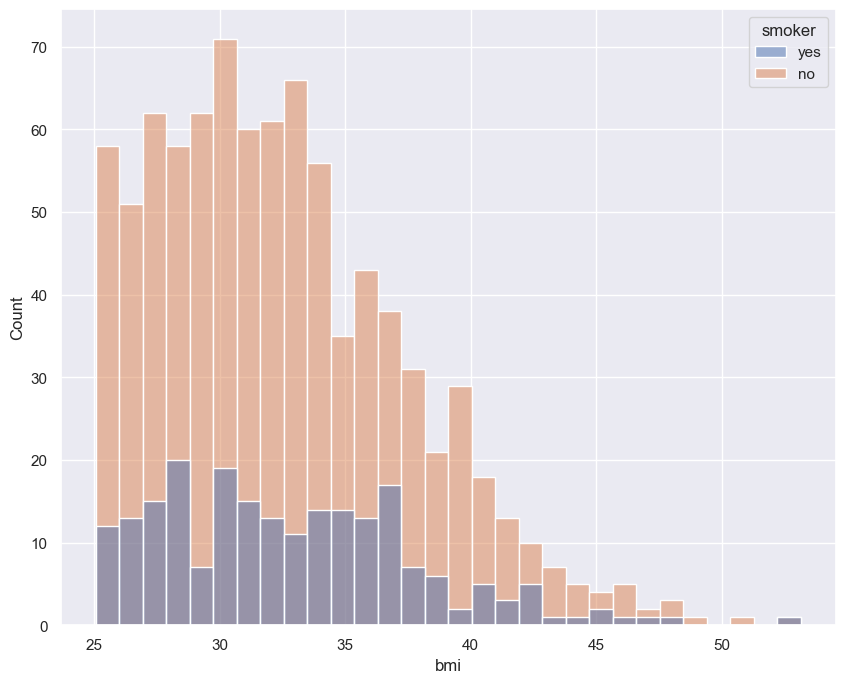

In [219]:
sns.histplot(data =df_peso2, x = "bmi", hue = "smoker",bins=30); 

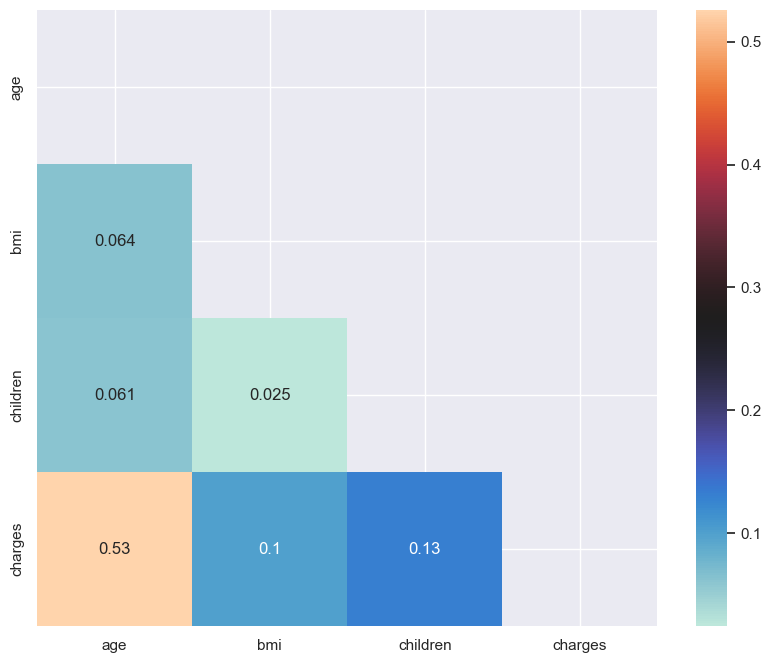

In [220]:
mask = np.triu(np.ones_like(df_peso2.corr(), dtype = np.bool))
sns.heatmap(df_peso2.corr(method="spearman"), 
           cmap = "icefire", 
            mask = mask,
           annot = True);


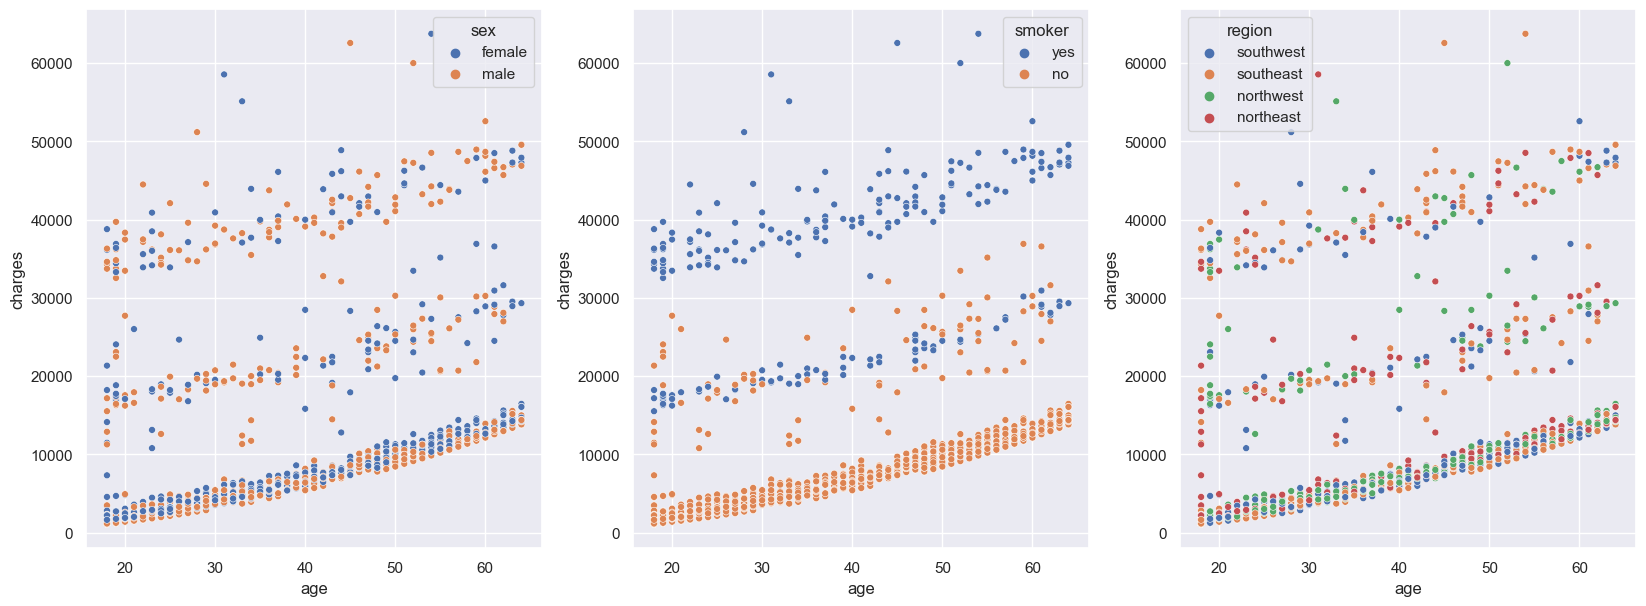

In [108]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso2.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='age', y='charges', data = df_peso2,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

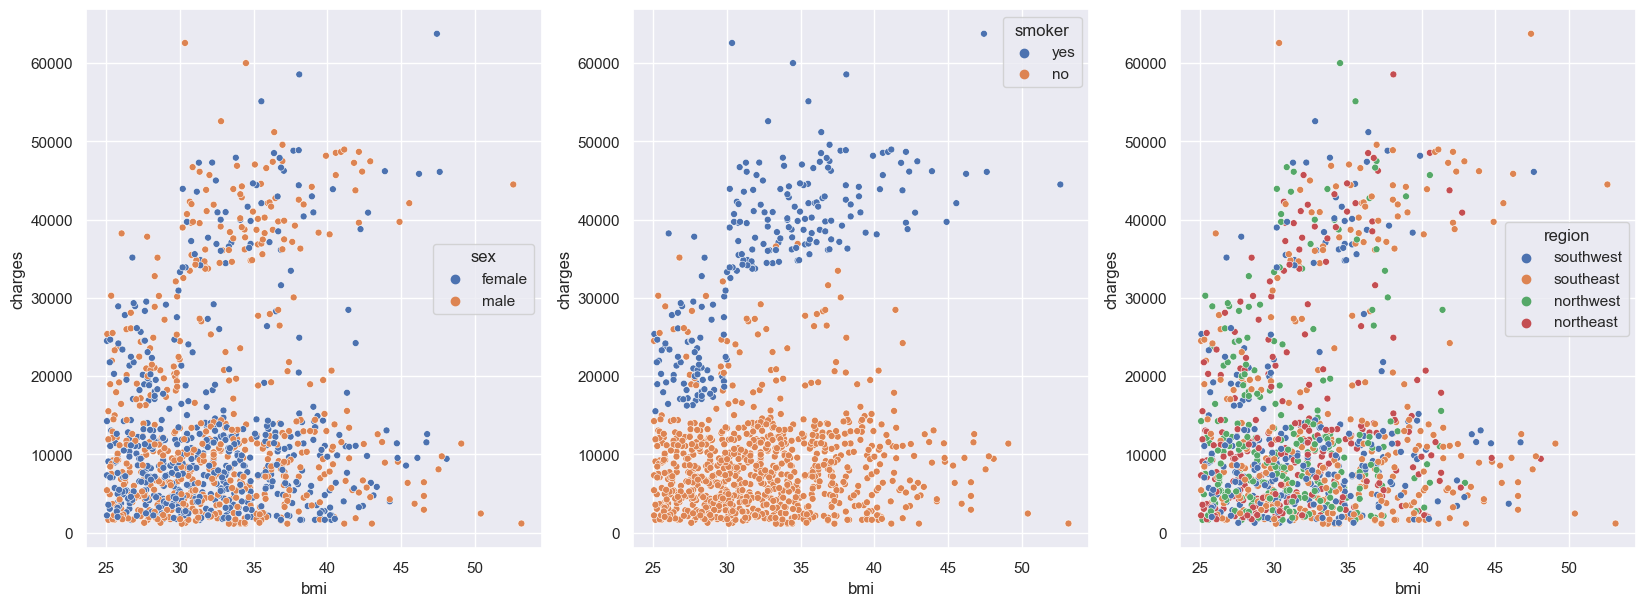

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
categoricas=df_peso2.select_dtypes(include='object')
for i in range(len(categoricas.columns)): 
    sns.scatterplot(x='bmi', y='charges', data = df_peso2,
                    s = 25,
                    hue = categoricas.columns[i], 
                    ax=axes[i])   
plt.show(); 

### In the case of unhealthy BMI, there is a clear tendency for charges to rise with age, and at the same time, we see that it also depends on smoking habits, clearly they are higher when smokers at all ages. The highest band of charges (almost exclusively for smokers) reappears, so we assume that the first risk factor for large premiums is smoking (the low premiums up to 15000 always correspond to non-smokers regardless of BMI) which is aggravated by unhealthy BMI and that the trend of charge in the groups is upward with age.

## So :
- smoker+unhealthy bmi(increase with age)
- smoker+healthy bmi(increase with age)
- non-smoker+unhealthy bmi(increase with age)
- non-smoker+healthy bmi(increase with age)

## From here, we remove non-smokers (lower premiums only correlated with age), and split the data between healthy and unhealthy BMI, to find correlations between variables.

### We are going to decide whether to split our dataset based on the predictor variables that we see that can condition our distribution of the response variable data, in our case, we are going to study whether to split it according to smoking habits or according to age.

## Smokers

In [113]:
dffum = df[(df['smoker'] == 'yes')]
dffum.sample(5)

age     sex    bmi  children smoker     region      charges
741    27    male  29.15         0    yes  southeast  18246.49550
82     22    male  37.62         1    yes  southeast  37165.16380
123    44    male  31.35         1    yes  northeast  39556.49450
1303   43    male  27.80         0    yes  southwest  37829.72420
1223   20  female  24.42         0    yes  southeast  26125.67477

In [114]:
numericas1 = dffum.select_dtypes(include = np.number)
numericas1.head(2)

age    bmi  children     charges
0    19  27.90         0  16884.9240
11   62  26.29         0  27808.7251

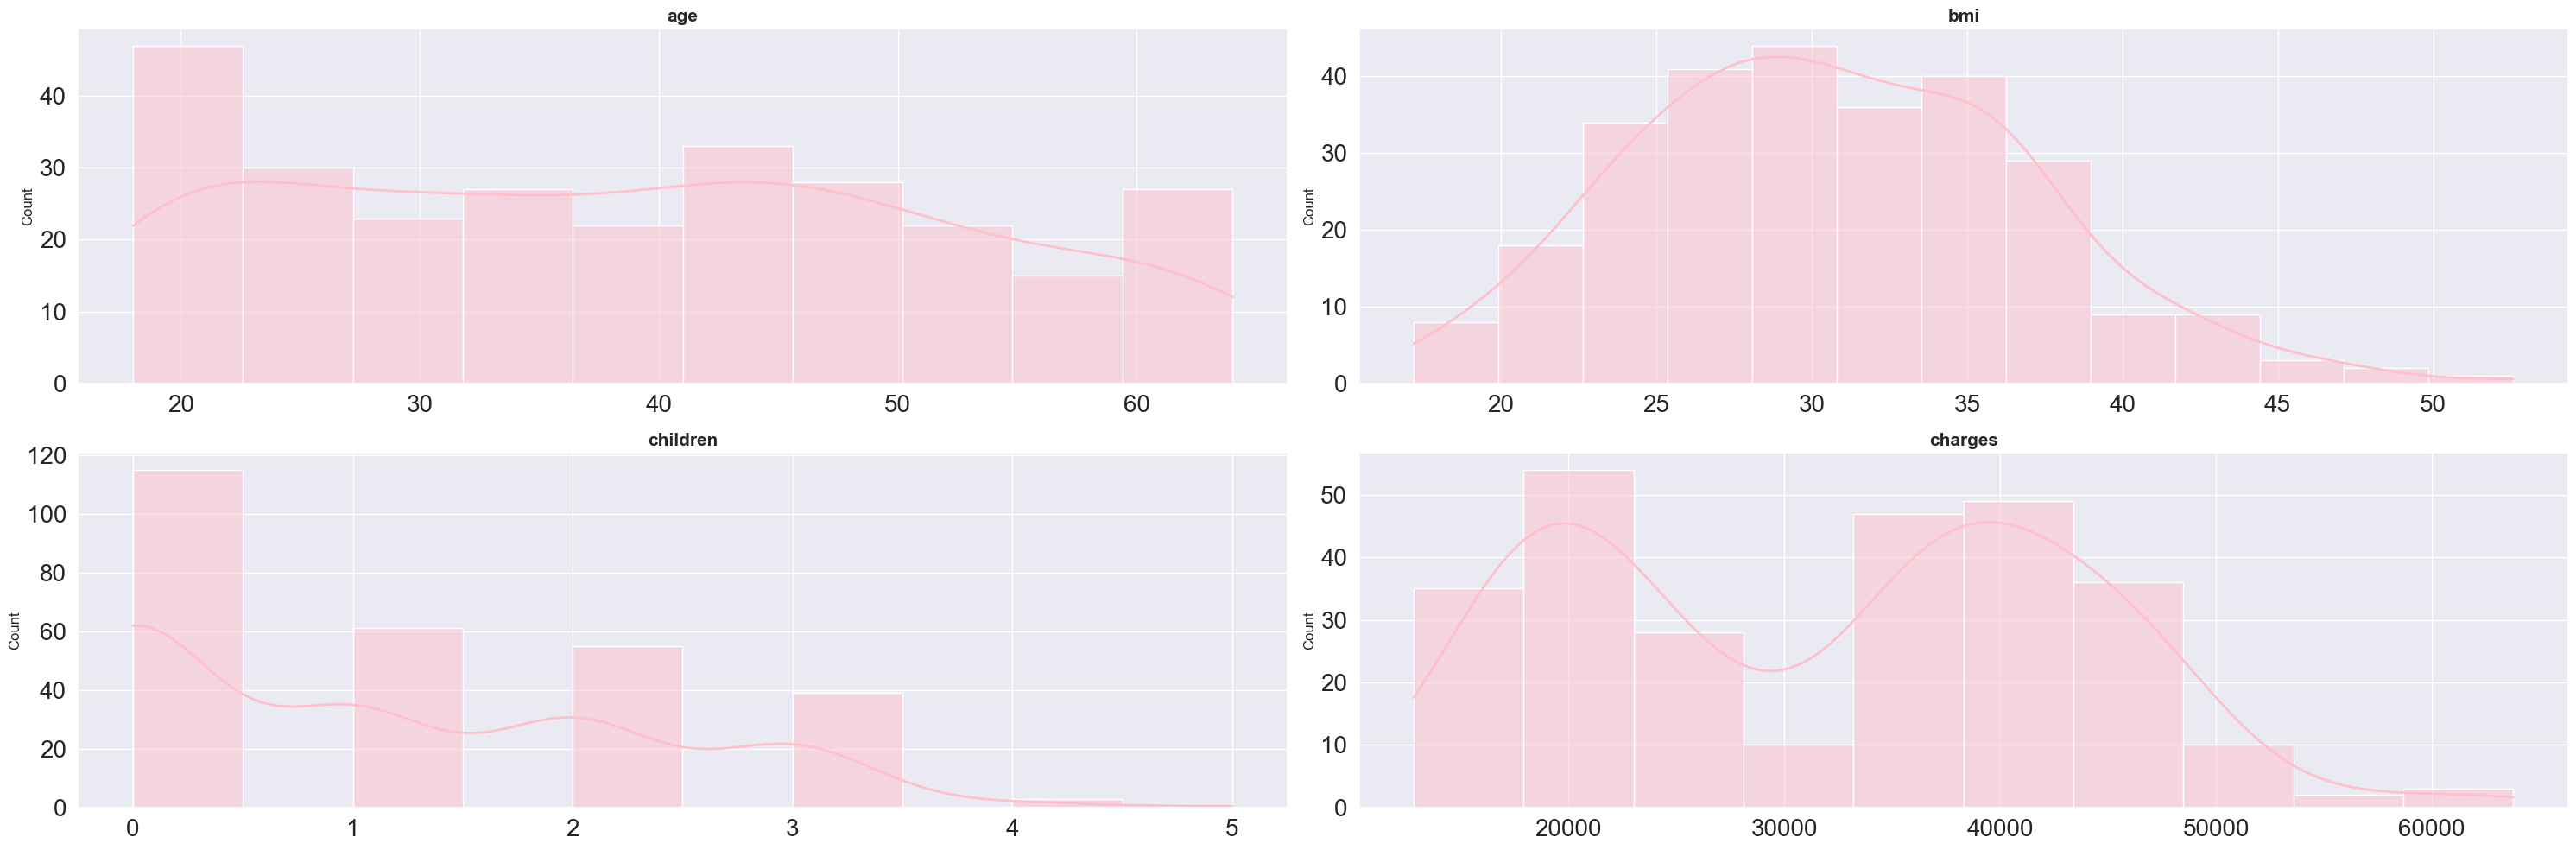

In [115]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas1.columns): 
    sns.histplot(
        data = numericas1[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

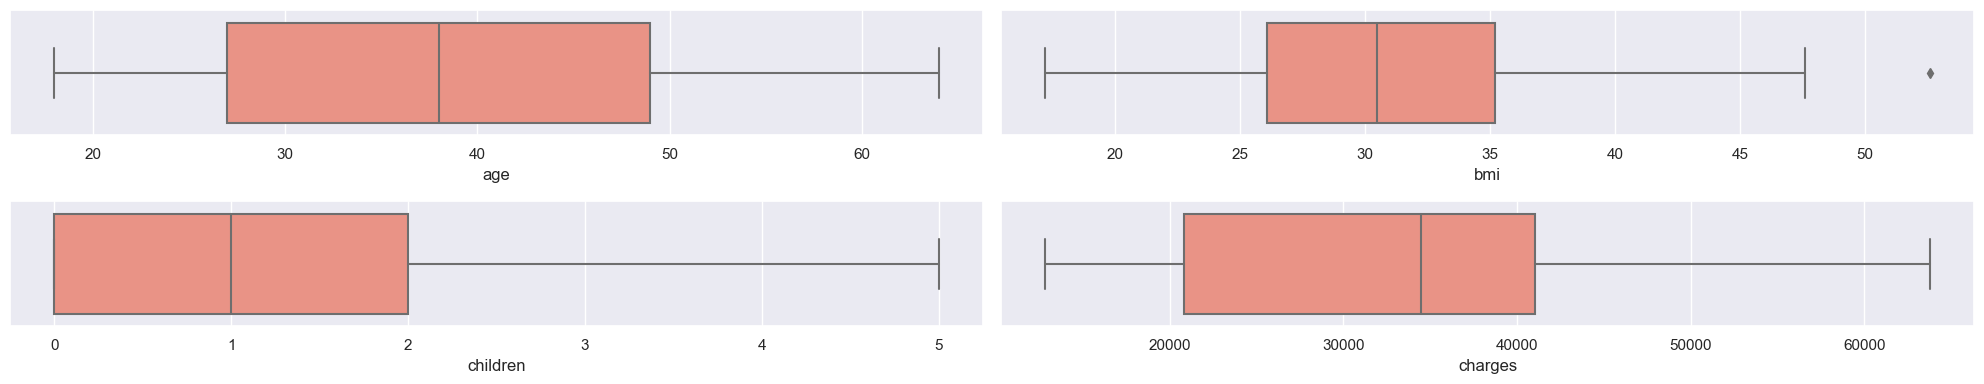

In [116]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas1.columns):
    sns.boxplot(x = numericas1[columna], data = dffum, ax=axes[indice], color = "#fa8775"); # para trazar una línea de densidad 
plt.tight_layout()
plt.show();

In [173]:
dffum.corr(method='spearman')

age       bmi  children   charges
age       1.000000  0.057876  0.111973  0.451876
bmi       0.057876  1.000000  0.011178  0.834228
children  0.111973  0.011178  1.000000  0.086998
charges   0.451876  0.834228  0.086998  1.000000

In [172]:
pg.partial_corr(data=dffum, x='age', y='charges', covar='bmi', method='spearman')

n         r         CI95%         p-val
spearman  274  0.733146  [0.67, 0.78]  2.759257e-47

In [171]:
pg.partial_corr(data=dffum, x='bmi', y='charges', covar='age', method='spearman')

n         r         CI95%          p-val
spearman  274  0.907352  [0.88, 0.93]  5.387764e-104

The three variables are related to each other, blocking them alternatively, positive correlations with positions increase.

### BMI <25

In [117]:

dffum_saludable=dffum[dffum['bmi']<25]

In [118]:
dffum_saludable.describe(include='all')

age     sex        bmi   children smoker     region  \
count   55.000000      55  55.000000  55.000000     55         55   
unique        NaN       2        NaN        NaN      1          4   
top           NaN  female        NaN        NaN    yes  northeast   
freq          NaN      32        NaN        NaN     55         22   
mean    37.309091     NaN  22.277182   1.236364    NaN        NaN   
std     12.480908     NaN   2.182447   1.261446    NaN        NaN   
min     18.000000     NaN  17.195000   0.000000    NaN        NaN   
25%     27.500000     NaN  20.710000   0.000000    NaN        NaN   
50%     38.000000     NaN  22.895000   1.000000    NaN        NaN   
75%     45.500000     NaN  24.130000   2.000000    NaN        NaN   
max     64.000000     NaN  24.890000   5.000000    NaN        NaN   

             charges  
count      55.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    19839.278309  
std      4583.245438  
min     12829.455100  
25%     16499.137025  
50%     19361.998800  
75%     22049.467450  
max     35069.374520

In [124]:
numericas_fum_saludables = dffum_saludable.select_dtypes(include = np.number)
numericas_fum_saludables.head(2)

age    bmi  children     charges
58   53  22.88         1  23244.7902
64   20  22.42         0  14711.7438

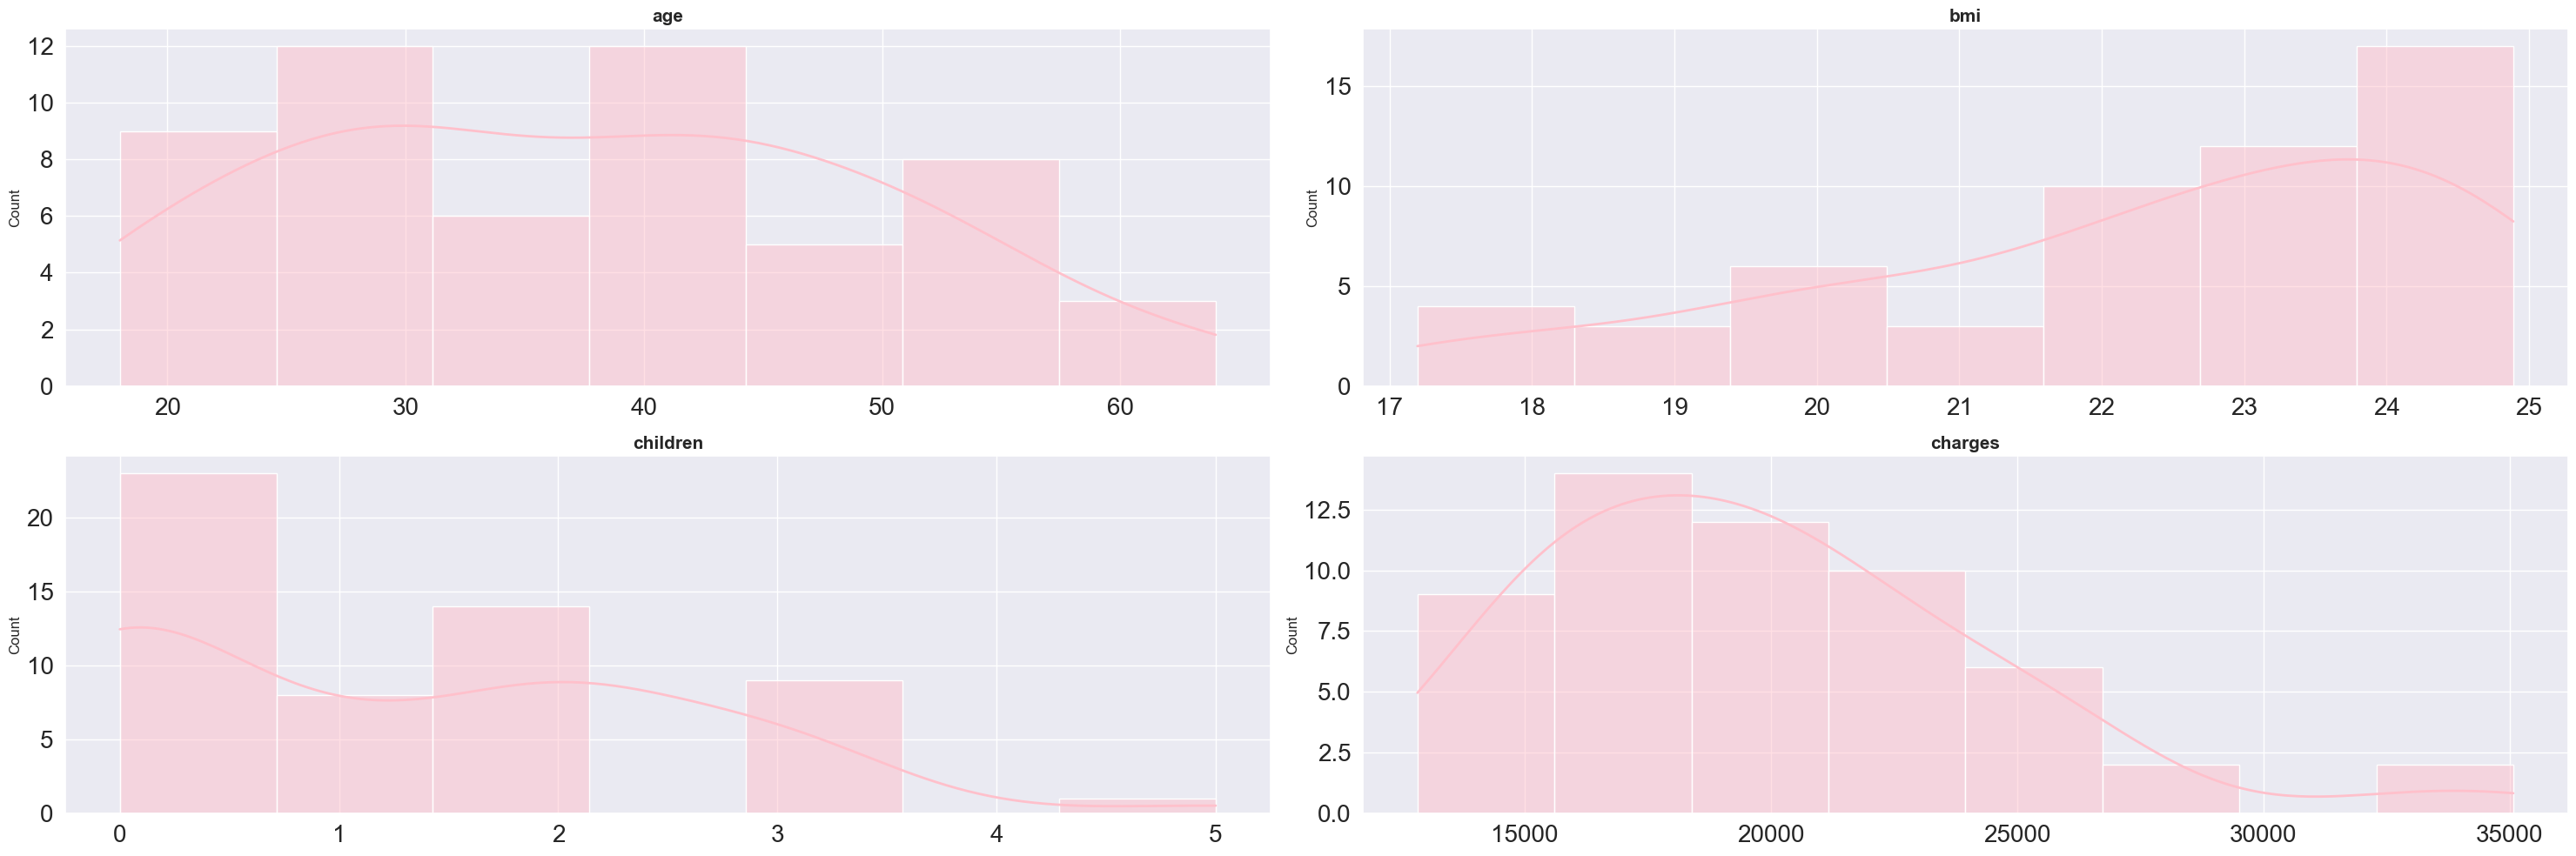

In [125]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas_fum_saludables.columns): 
    sns.histplot(
        data = numericas_fum_saludables[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

In [158]:
shapiro_test = stats.shapiro(numericas_fum_saludables.age)
print(f"Variable age: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_saludables.bmi)
print(f"Variable bmi: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_saludables.charges)
print(f"Variable charges: {shapiro_test}")

Variable age: ShapiroResult(statistic=0.9636784195899963, pvalue=0.09510397911071777)
Variable bmi: ShapiroResult(statistic=0.9075034856796265, pvalue=0.00045880640391260386)
Variable charges: ShapiroResult(statistic=0.9331294298171997, pvalue=0.004410581663250923)


In [159]:
k2, p_value = stats.normaltest(numericas_fum_saludables.age)
print(f"Variable age: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.bmi)
print(f"Variable bmi: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.charges)
print(f"Variable charges: Estadítico = {k2}, p-value = {p_value}")

Variable age: Estadítico = 3.7841944401285836, p-value = 0.15075531000758297
Variable bmi: Estadítico = 5.767728447442714, p-value = 0.055918264121129095
Variable charges: Estadítico = 13.320477515883951, p-value = 0.0012808405230266449


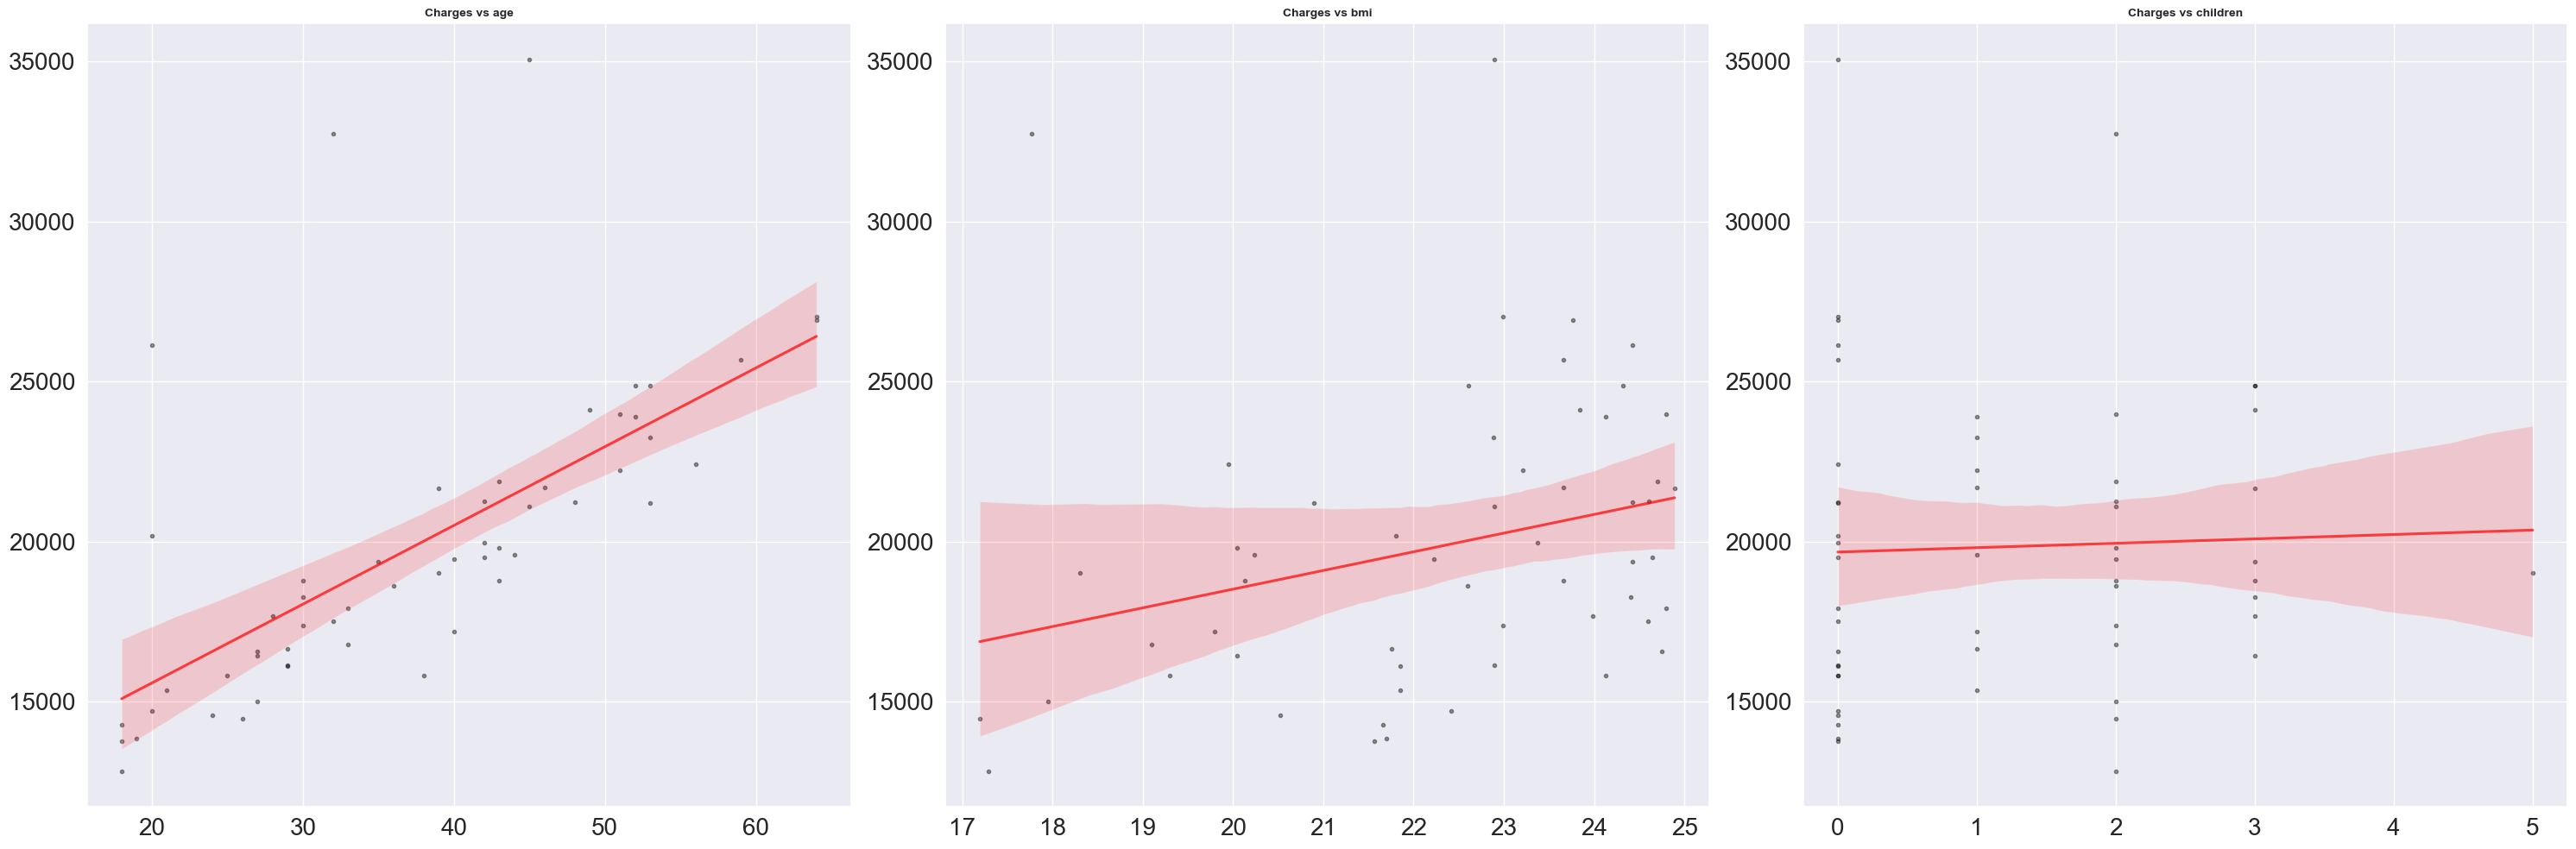

In [230]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
numericas = numericas_fum_saludables.drop("charges", axis=1) 
for i, colum in enumerate(numericas):
    sns.regplot(
        x = dffum_saludable[colum], 
        y = dffum_saludable["charges"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    axes[i].set_title(f"Charges vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

In [153]:
dffum_saludable.corr(method = 'spearman')

age       bmi  children   charges
age       1.000000  0.245382  0.089837  0.799567
bmi       0.245382  1.000000 -0.036167  0.393844
children  0.089837 -0.036167  1.000000  0.108410
charges   0.799567  0.393844  0.108410  1.000000

In [155]:
dffum_saludable.corr(method = 'pearson')

age       bmi  children   charges
age       1.000000  0.251514  0.048204  0.670269
bmi       0.251514  1.000000 -0.139767  0.278094
children  0.048204 -0.139767  1.000000  0.037743
charges   0.670269  0.278094  0.037743  1.000000

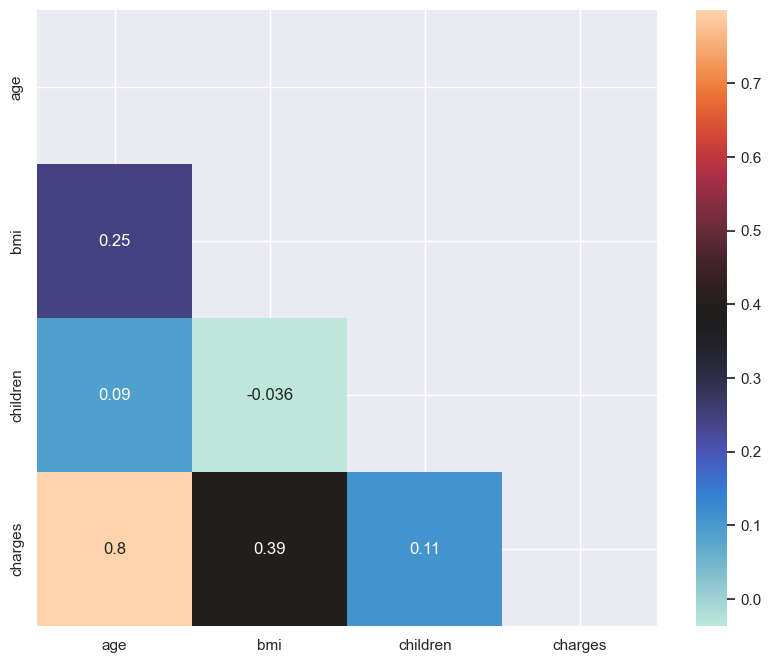

In [154]:
mask = np.triu(np.ones_like(dffum_saludable.corr(method = 'spearman'), dtype = np.bool))
sns.heatmap(dffum_saludable.corr(method = 'spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

In [167]:
display(pg.corr(dffum_saludable['age'], dffum_saludable['charges'], method='pearson'))
display(pg.corr(dffum_saludable['age'], dffum_saludable['charges'], method='spearman'))
display(pg.corr(dffum_saludable['age'], dffum_saludable['charges'], method='kendall'))

n         r         CI95%         p-val       BF10     power
pearson  55  0.670269  [0.49, 0.79]  2.174499e-08  7.042e+05  0.999958

n         r         CI95%         p-val  power
spearman  55  0.799567  [0.68, 0.88]  2.481337e-13    1.0

n         r         CI95%         p-val     power
kendall  55  0.686903  [0.52, 0.81]  2.265867e-13  0.999984

### BMI >25

In [121]:

dffum_no_saludable=dffum[dffum['bmi']>25]

In [122]:
dffum_no_saludable.describe(include='all')

age   sex         bmi    children smoker     region  \
count   219.000000   219  219.000000  219.000000    219        219   
unique         NaN     2         NaN         NaN      1          4   
top            NaN  male         NaN         NaN    yes  southeast   
freq           NaN   136         NaN         NaN    219         77   
mean     38.817352   NaN   32.825890    1.082192    NaN        NaN   
std      14.273009   NaN    5.136105    1.130317    NaN        NaN   
min      18.000000   NaN   25.100000    0.000000    NaN        NaN   
25%      25.500000   NaN   28.345000    0.000000    NaN        NaN   
50%      38.000000   NaN   32.015000    1.000000    NaN        NaN   
75%      50.000000   NaN   36.080000    2.000000    NaN        NaN   
max      64.000000   NaN   52.580000    4.000000    NaN        NaN   

             charges  
count     219.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    35116.909657  
std     10702.561195  
min     15518.180250  
25%     24601.558775  
50%     37270.151200  
75%     42808.670100  
max     63770.428010

In [138]:
numericas_fum_no_saludables = dffum_no_saludable.select_dtypes(include = np.number)
numericas_fum_no_saludables.head(2)

age    bmi  children     charges
0    19  27.90         0  16884.9240
11   62  26.29         0  27808.7251

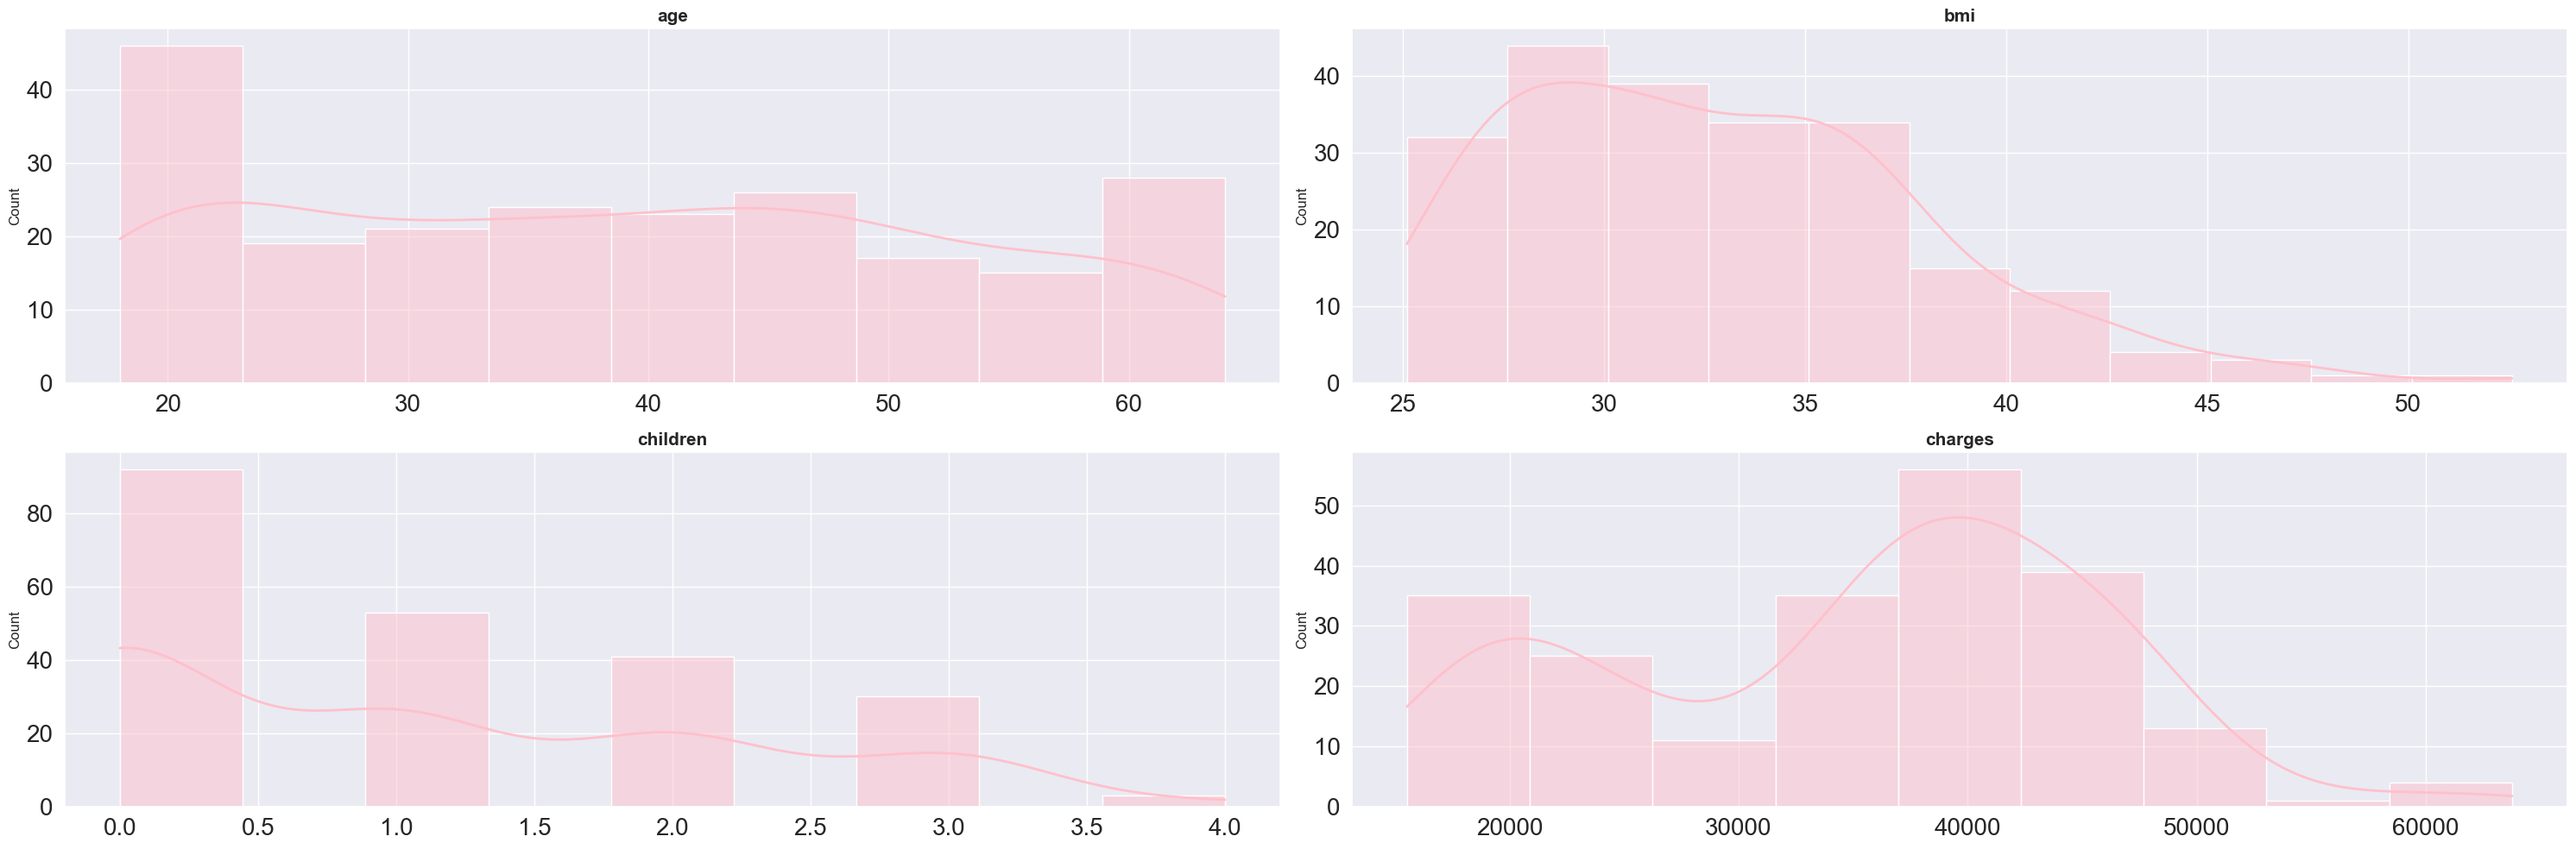

In [139]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas_fum_no_saludables.columns): 
    sns.histplot(
        data = numericas_fum_no_saludables[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5, 
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

In [160]:
shapiro_test = stats.shapiro(numericas_fum_no_saludables.age)
print(f"Variable age: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_no_saludables.bmi)
print(f"Variable bmi: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_fum_no_saludables.charges)
print(f"Variable charges: {shapiro_test}")

Variable age: ShapiroResult(statistic=0.9417991042137146, pvalue=1.1172188152386298e-07)
Variable bmi: ShapiroResult(statistic=0.9536837935447693, pvalue=1.6536107523279497e-06)
Variable charges: ShapiroResult(statistic=0.9477157592773438, pvalue=4.0925593225438206e-07)


In [161]:
k2, p_value = stats.normaltest(numericas_fum_saludables.age)
print(f"Variable age: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.bmi)
print(f"Variable bmi: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_fum_saludables.charges)
print(f"Variable charges: Estadítico = {k2}, p-value = {p_value}")

Variable age: Estadítico = 3.7841944401285836, p-value = 0.15075531000758297
Variable bmi: Estadítico = 5.767728447442714, p-value = 0.055918264121129095
Variable charges: Estadítico = 13.320477515883951, p-value = 0.0012808405230266449


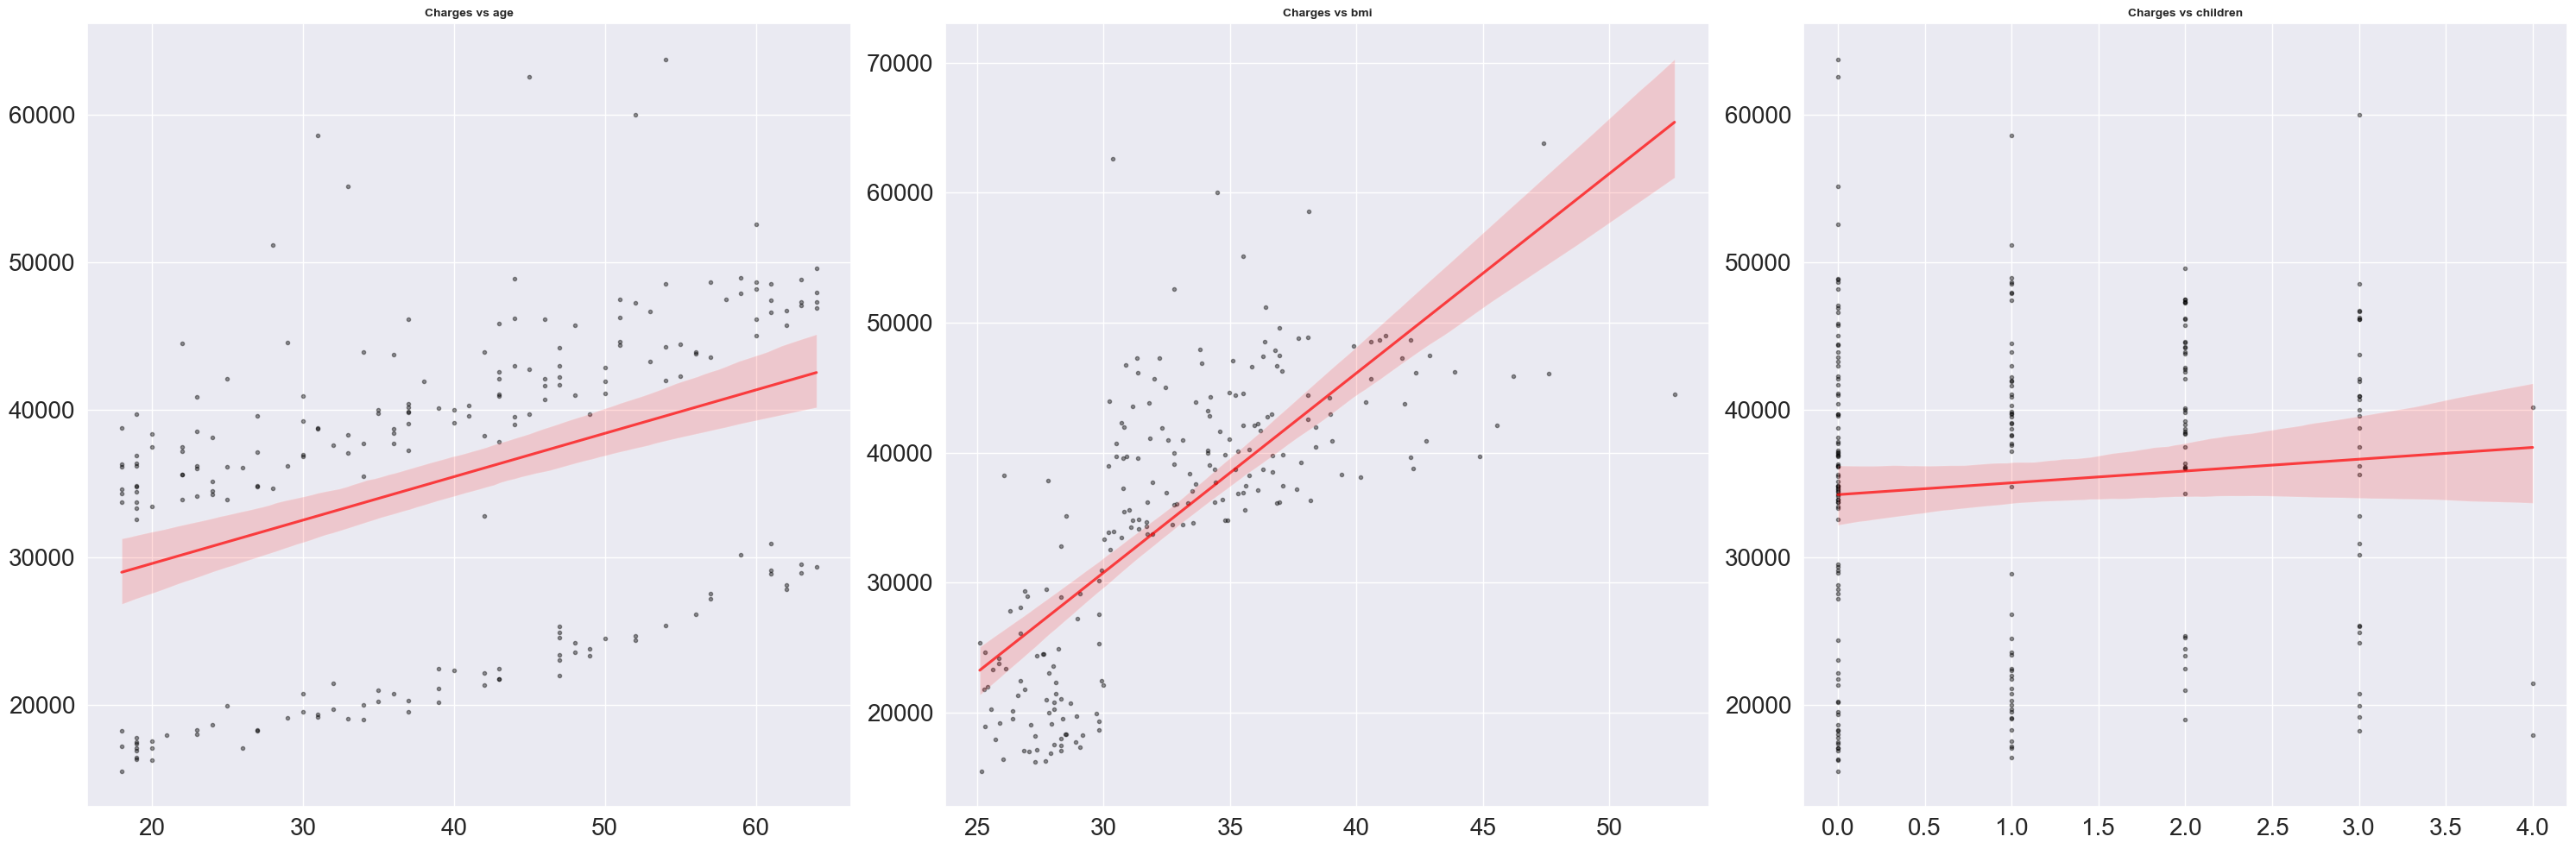

In [141]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
numericas = numericas_fum_no_saludables.drop("charges", axis=1) 

for i, colum in enumerate(numericas):
    sns.regplot(
        x = dffum_no_saludable[colum], 
        y = dffum_no_saludable["charges"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])  
    axes[i].set_title(f"Charges vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")   
fig.tight_layout();

In [150]:
dffum_no_saludable.corr(method = 'spearman')#are not normally distributed

age       bmi  children   charges
age       1.000000  0.033279  0.119622  0.486586
bmi       0.033279  1.000000  0.066277  0.784544
children  0.119622  0.066277  1.000000  0.141579
charges   0.486586  0.784544  0.141579  1.000000

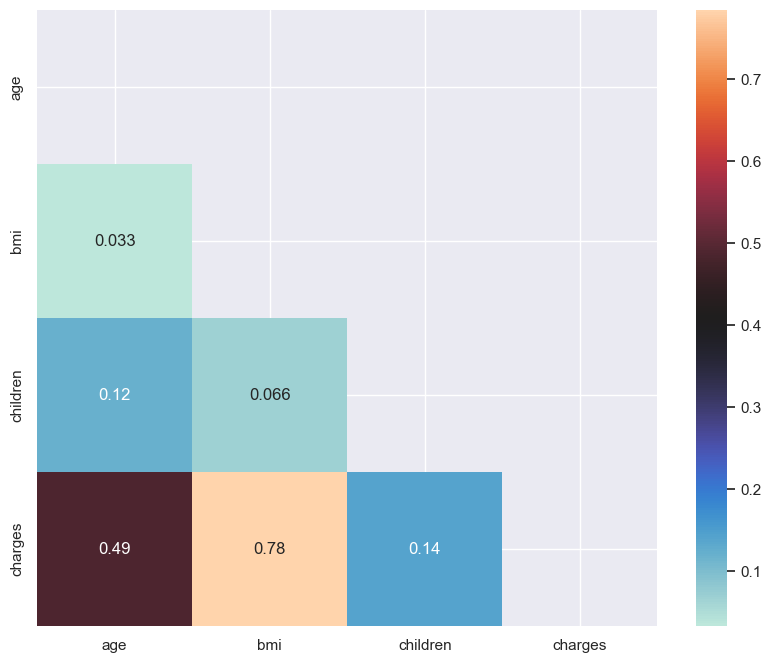

In [152]:
mask = np.triu(np.ones_like(dffum_no_saludable.corr(method = 'spearman'), dtype = np.bool))
sns.heatmap(dffum_no_saludable.corr(method = 'spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

In [165]:
display(pg.corr(dffum_no_saludable['bmi'], dffum_no_saludable['charges'], method='pearson'))
display(pg.corr(dffum_no_saludable['bmi'], dffum_no_saludable['charges'], method='spearman'))
display(pg.corr(dffum_no_saludable['bmi'], dffum_no_saludable['charges'], method='kendall'))

n         r         CI95%         p-val       BF10  power
pearson  219  0.736148  [0.67, 0.79]  1.195008e-38  2.401e+35    1.0

n         r         CI95%         p-val  power
spearman  219  0.784544  [0.73, 0.83]  6.274185e-47    1.0

n         r         CI95%         p-val  power
kendall  219  0.573352  [0.48, 0.66]  1.805820e-36    1.0

### We see that the biggest risk factor is smoke status positive, in the case of healthy BMI, the premium value correlates with age and in the case of unhealthy BMI, with the BMI value. And from BMI 30 onwards there is a large increase in the value of the premiums.

---

## Nonsmokers

In [238]:
df2 = df[(df['smoker'] == 'no')]
df2.sample(5)

age     sex     bmi  children smoker     region      charges charges_bins
657   27    male  33.155         2     no  northwest   4058.71245        bajas
56    58  female  31.825         2     no  northeast  13607.36875        bajas
571   18  female  37.290         1     no  southeast   2219.44510        bajas
167   32  female  33.155         3     no  northwest   6128.79745        bajas
275   47  female  26.600         2     no  northeast   9715.84100        bajas

In [239]:
df2.shape

(1064, 8)

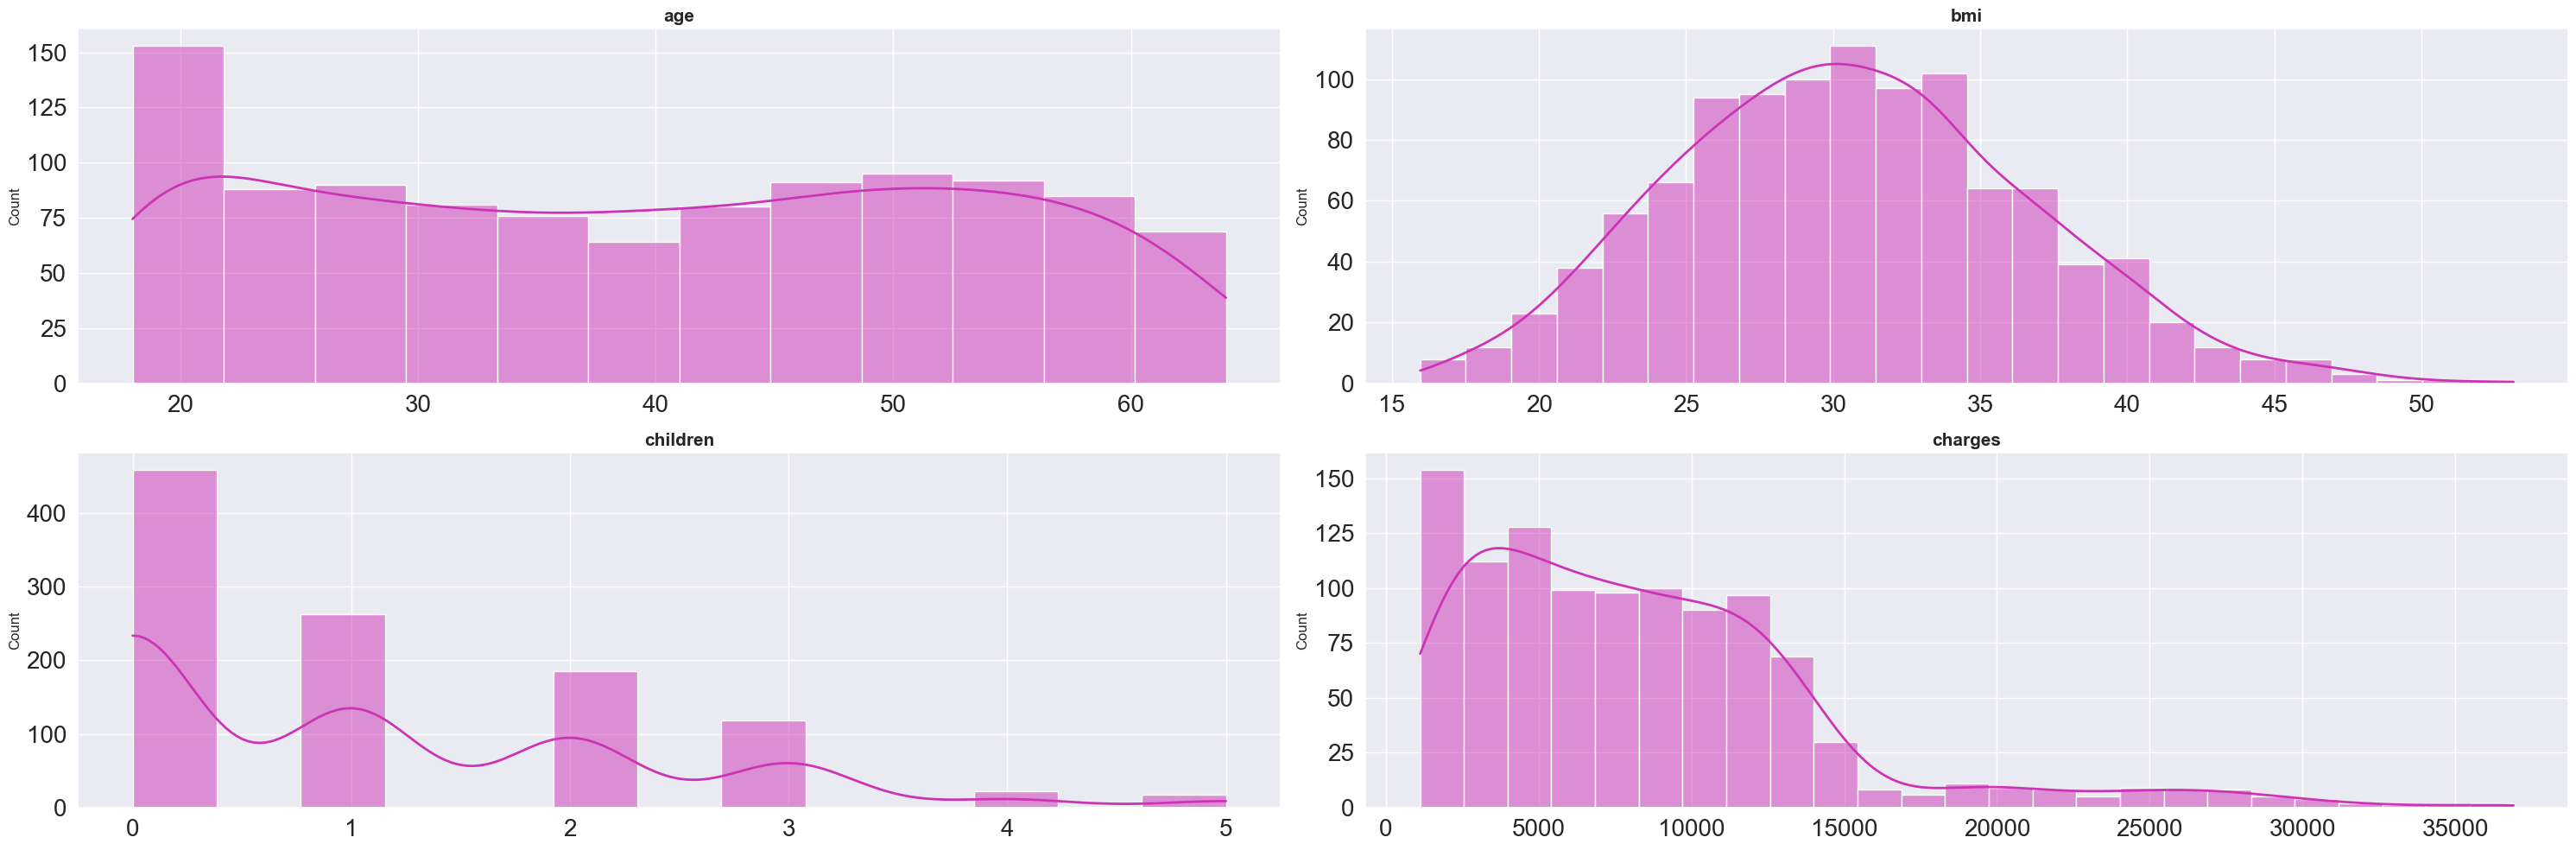

In [240]:
numericas2 = df2.select_dtypes(include = np.number)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas2.columns): 
    sns.histplot(
        data = numericas2[colum],
        kde = True,
        color = "#cd34b5", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

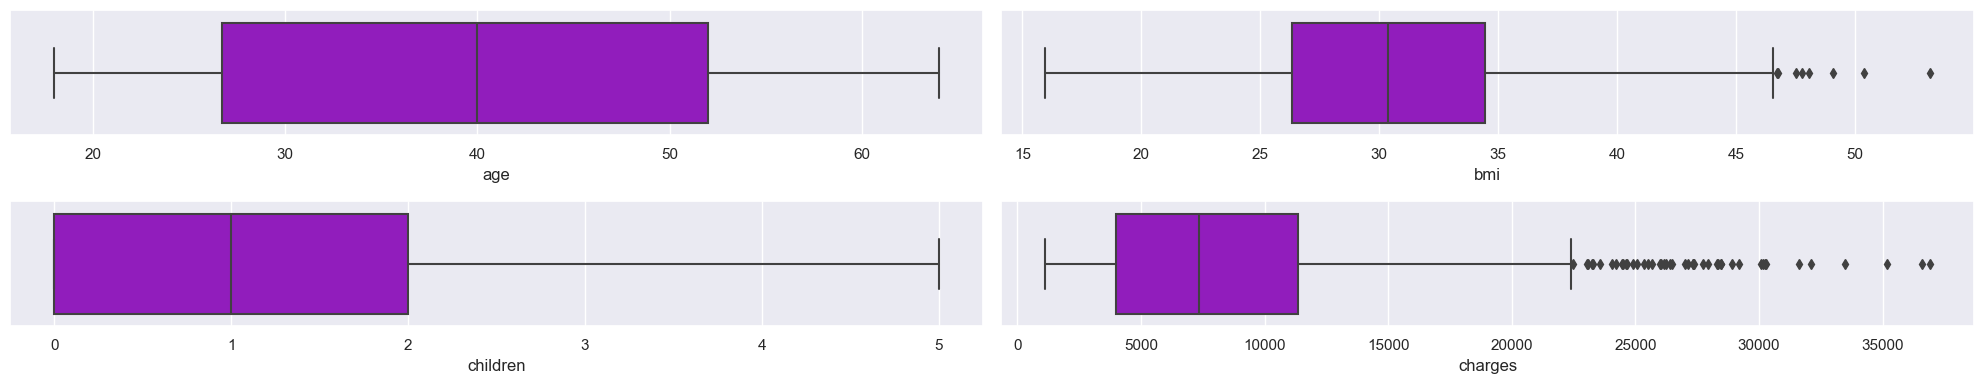

In [241]:
fig, axes = plt.subplots(2,2, figsize=(20,4))
axes = axes.flat
for indice, columna in enumerate(numericas2.columns):
    sns.boxplot(x = numericas2[columna], data = df2, ax=axes[indice], color = "#9d02d7");
plt.tight_layout()
plt.show();

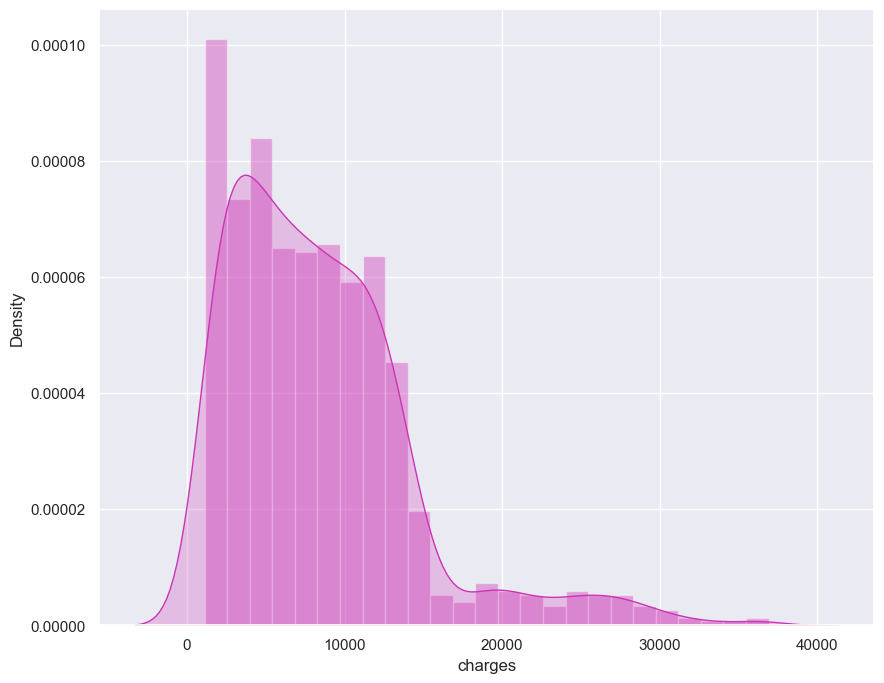

In [242]:
# vamos a ver visualmente como está distribuida la variable respuesta segun no fumadores
sns.set(style="ticks")
sns.set_style("darkgrid")
sns.distplot(
    df2["charges"], 
    #hist = False, 
    color = "#cd34b5", 
    kde_kws = {"shade": True, "linewidth": 1});

### BMI <25

In [266]:
dfnfum = df[(df['smoker'] != 'yes')]

In [267]:

dfnfum_saludable=dfnfum[dfnfum['bmi']<25]

In [268]:
dfnfum_saludable.describe(include='all')

age     sex         bmi    children smoker     region  \
count   190.000000     190  190.000000  190.000000    190        190   
unique         NaN       2         NaN         NaN      1          4   
top            NaN  female         NaN         NaN     no  northeast   
freq           NaN      97         NaN         NaN    190         61   
mean     36.105263     NaN   22.182684    1.089474    NaN        NaN   
std      13.935204     NaN    2.085928    1.233310    NaN        NaN   
min      18.000000     NaN   15.960000    0.000000    NaN        NaN   
25%      23.250000     NaN   20.825000    0.000000    NaN        NaN   
50%      34.000000     NaN   22.610000    1.000000    NaN        NaN   
75%      47.000000     NaN   23.845000    2.000000    NaN        NaN   
max      64.000000     NaN   24.985000    5.000000    NaN        NaN   

             charges charges_bins  
count     190.000000          190  
unique           NaN            1  
top              NaN        bajas  
freq             NaN          190  
mean     7515.708891          NaN  
std      5721.958640          NaN  
min      1121.873900          NaN  
25%      3169.663812          NaN  
50%      6337.384275          NaN  
75%     10096.768700          NaN  
max     30166.618170          NaN

In [269]:
numericas_nfum_saludables = dfnfum_saludable.select_dtypes(include = np.number)
numericas_nfum_saludables.head(2)

age     bmi  children      charges
3    33  22.705         0  21984.47061
15   19  24.600         1   1837.23700

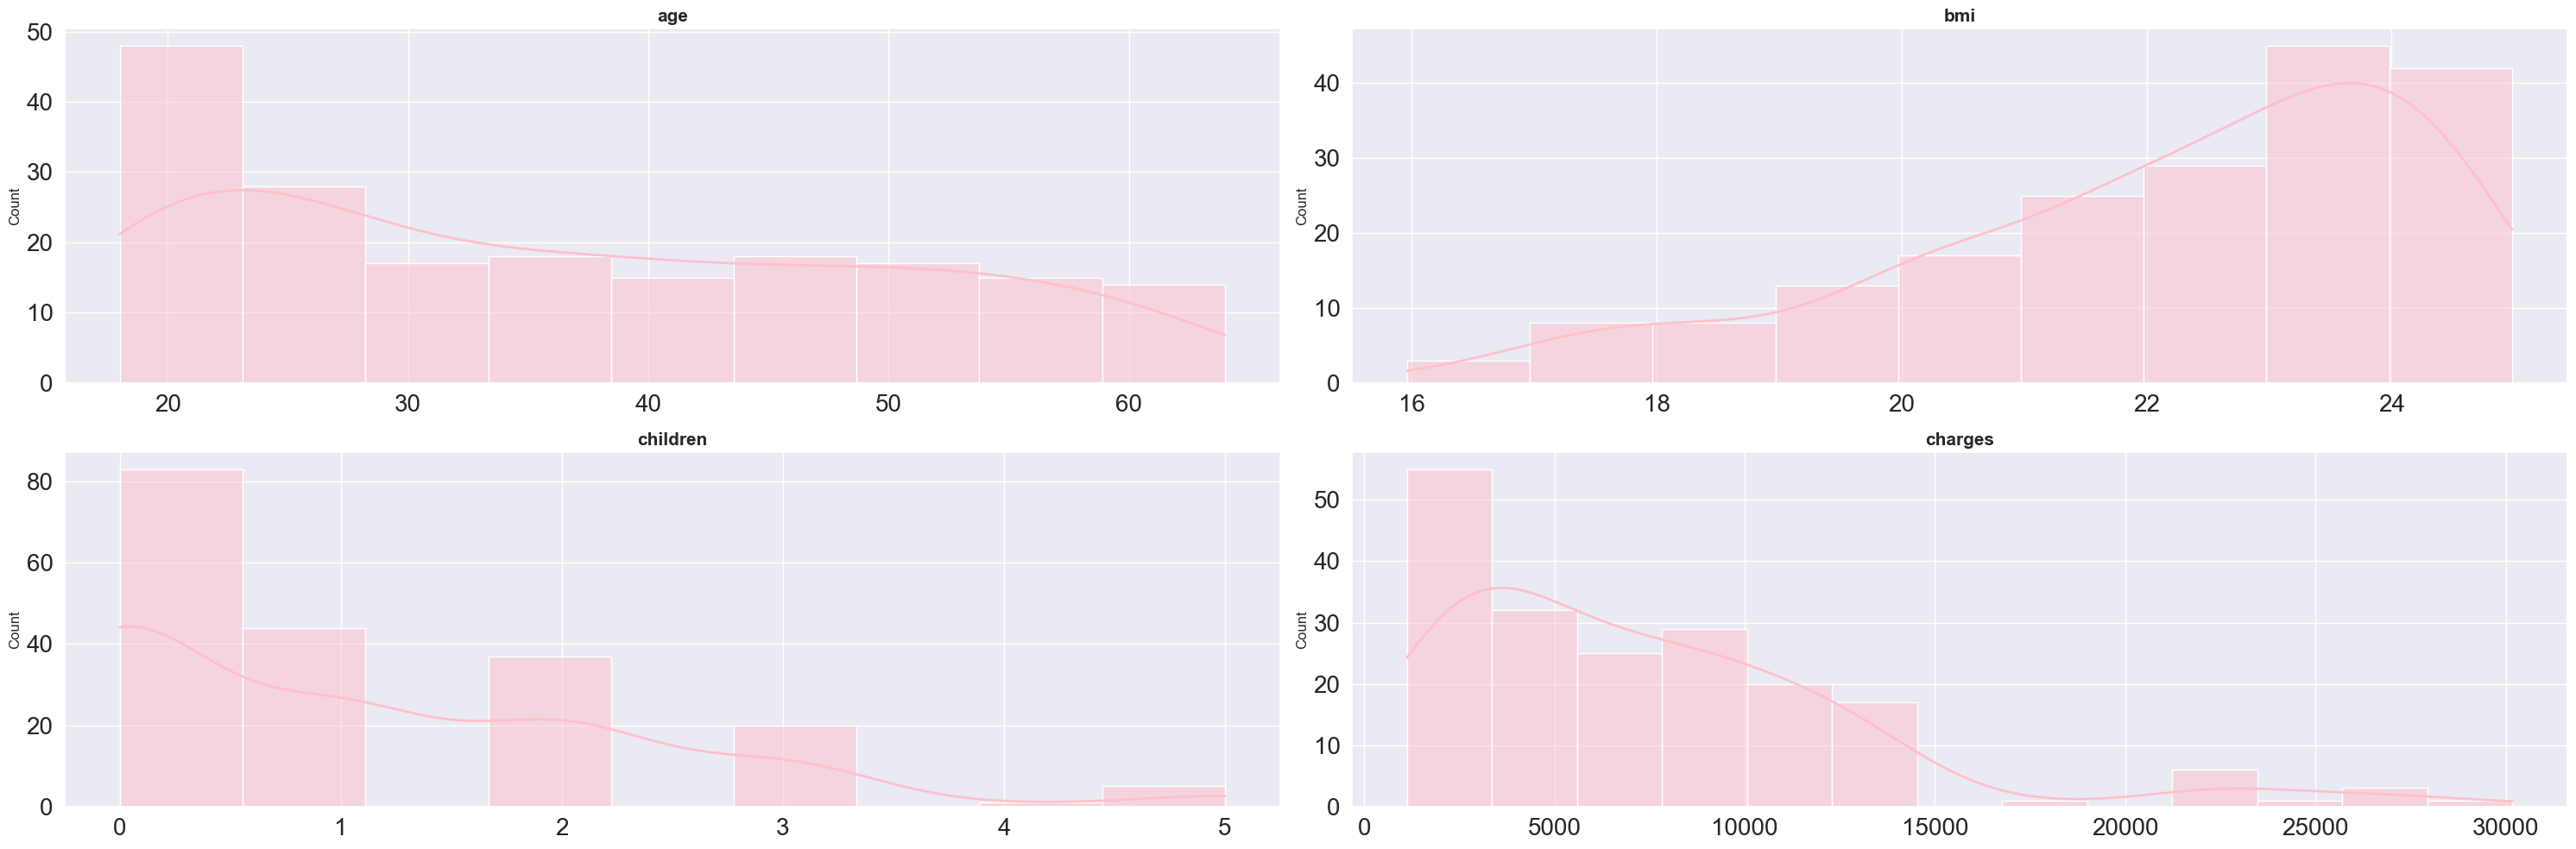

In [270]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas_nfum_saludables.columns): 
    sns.histplot(
        data = numericas_nfum_saludables[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, # para indicar el ancho de las líneas de las barras
        alpha = 0.5, # para especificar la transparencia del color
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

In [271]:
shapiro_test = stats.shapiro(numericas_nfum_saludables.age)
print(f"Variable age: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_nfum_saludables.bmi)
print(f"Variable bmi: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_nfum_saludables.charges)
print(f"Variable charges: {shapiro_test}")

Variable age: ShapiroResult(statistic=0.9247159957885742, pvalue=2.5429848449221026e-08)
Variable bmi: ShapiroResult(statistic=0.9234867691993713, pvalue=2.0621435226075846e-08)
Variable charges: ShapiroResult(statistic=0.8509225845336914, pvalue=1.1404856009242237e-12)


In [272]:
k2, p_value = stats.normaltest(numericas_nfum_saludables.age)
print(f"Variable age: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_nfum_saludables.bmi)
print(f"Variable bmi: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_nfum_saludables.charges)
print(f"Variable charges: Estadítico = {k2}, p-value = {p_value}")

Variable age: Estadítico = 76.31761999368219, p-value = 2.6781776558126344e-17
Variable bmi: Estadítico = 19.34205325220759, p-value = 6.308505731153563e-05
Variable charges: Estadítico = 64.16748735542456, p-value = 1.1646814593789961e-14


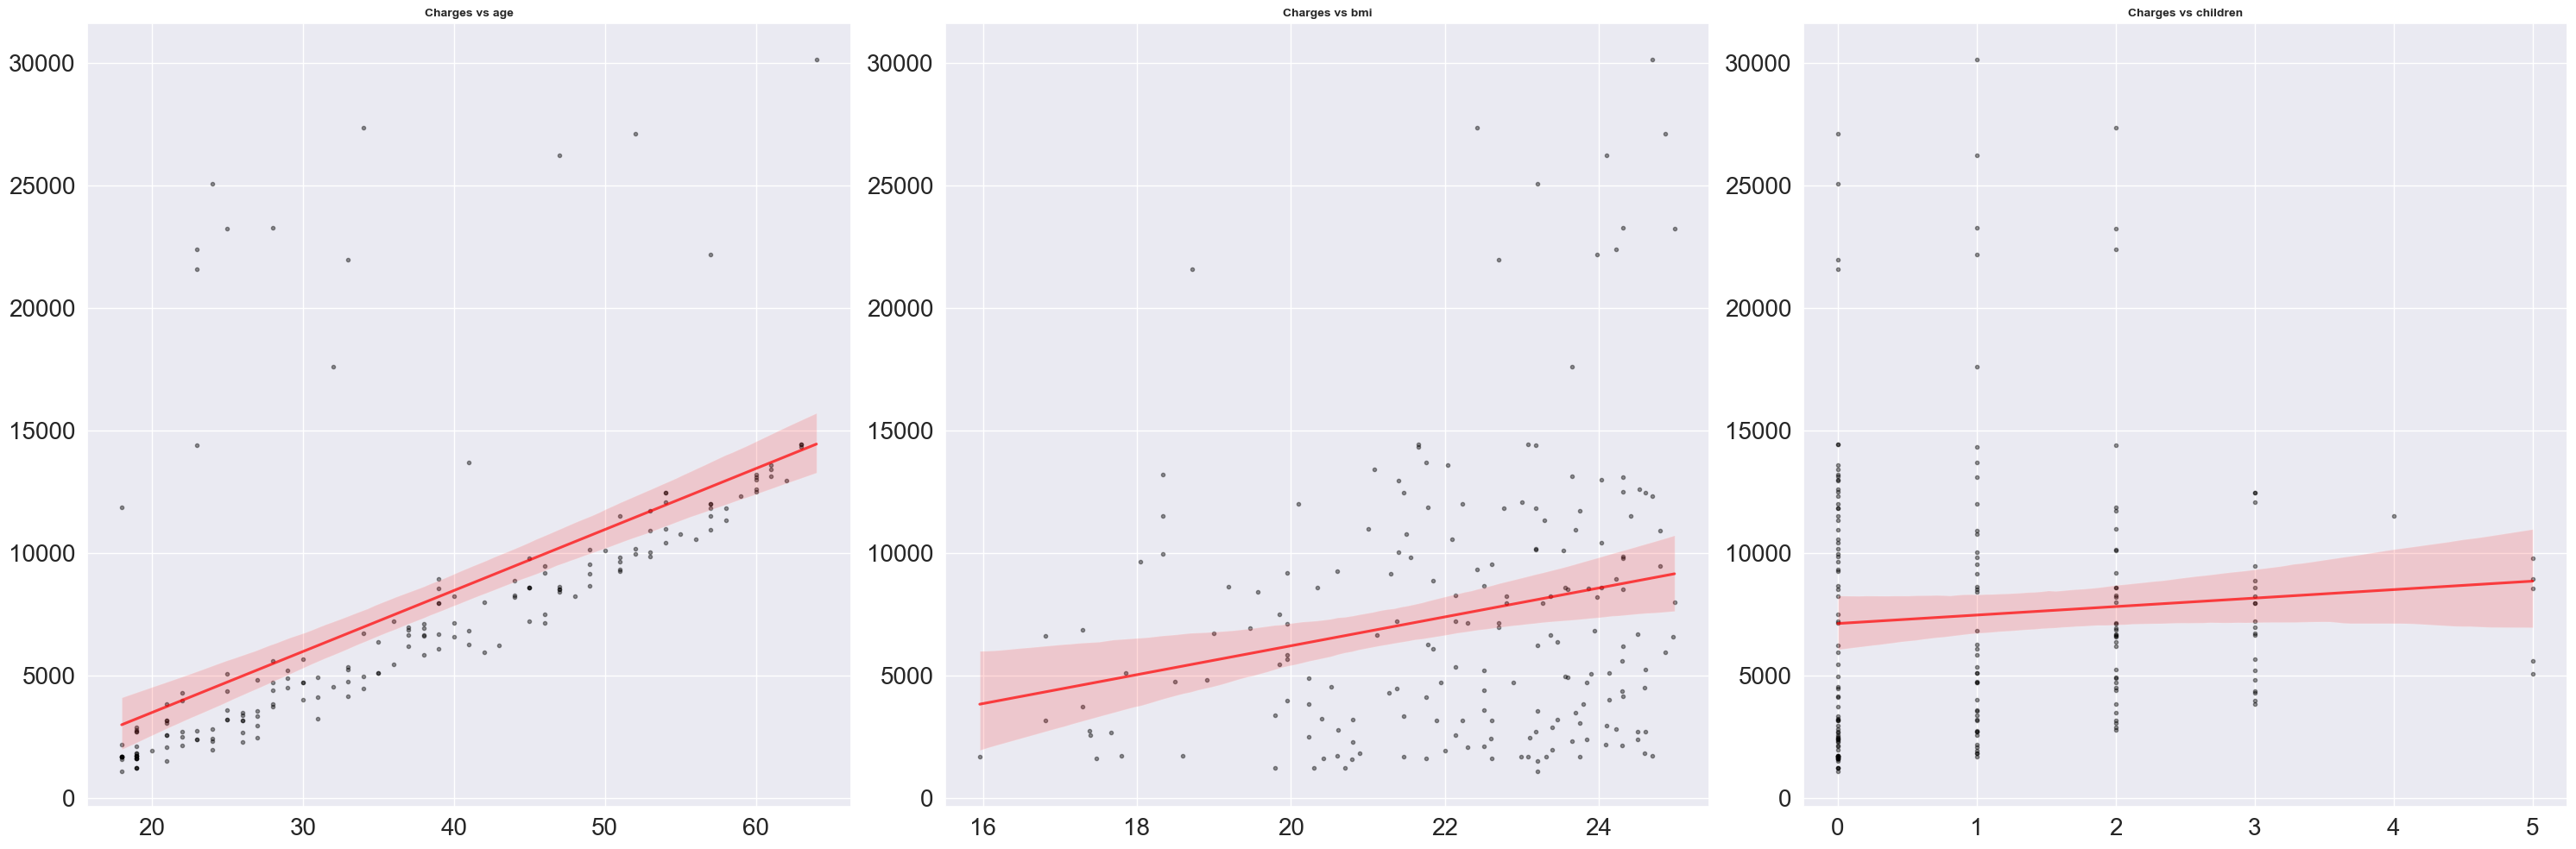

In [273]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
numericas = numericas_nfum_saludables.drop("charges", axis=1) 
for i, colum in enumerate(numericas):
    sns.regplot(
        x = dfnfum_saludable[colum], 
        y = dfnfum_saludable["charges"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    axes[i].set_title(f"Charges vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

In [274]:
dfnfum_saludable.corr(method = 'spearman')

age       bmi  children   charges
age       1.000000  0.126367  0.046698  0.829594
bmi       0.126367  1.000000  0.126093  0.184181
children  0.046698  0.126093  1.000000  0.194448
charges   0.829594  0.184181  0.194448  1.000000

In [275]:
dfnfum_saludable.corr(method = 'pearson')

age       bmi  children   charges
age       1.000000  0.136064 -0.001167  0.606393
bmi       0.136064  1.000000  0.142845  0.214944
children -0.001167  0.142845  1.000000  0.074536
charges   0.606393  0.214944  0.074536  1.000000

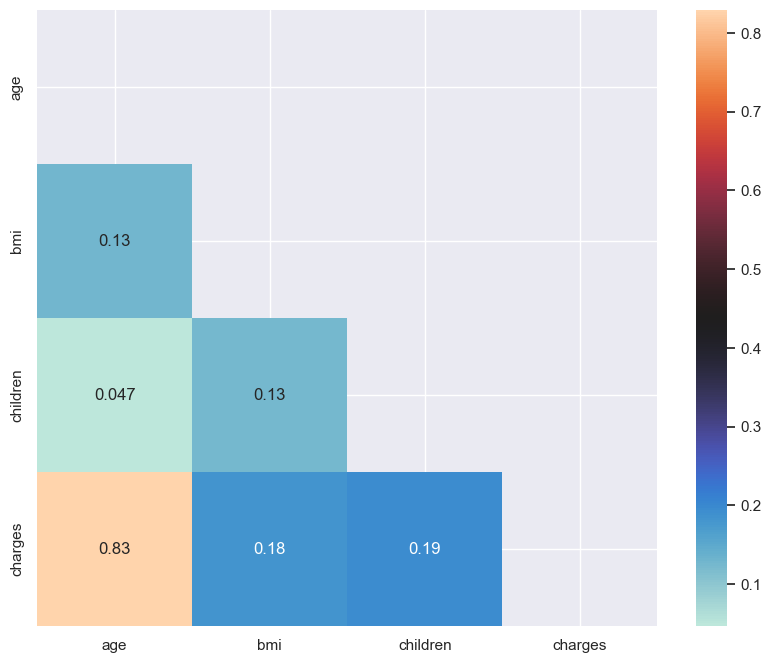

In [276]:
mask = np.triu(np.ones_like(dfnfum_saludable.corr(method = 'spearman'), dtype = np.bool))
sns.heatmap(dfnfum_saludable.corr(method = 'spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

In [277]:
display(pg.corr(dfnfum_saludable['age'], dfnfum_saludable['charges'], method='pearson'))
display(pg.corr(dfnfum_saludable['age'], dfnfum_saludable['charges'], method='spearman'))
display(pg.corr(dfnfum_saludable['age'], dfnfum_saludable['charges'], method='kendall'))

n         r         CI95%         p-val       BF10  power
pearson  190  0.606393  [0.51, 0.69]  1.835128e-20  2.998e+17    1.0

n         r         CI95%         p-val  power
spearman  190  0.829594  [0.78, 0.87]  1.842011e-49    1.0

n         r        CI95%         p-val  power
kendall  190  0.736908  [0.66, 0.8]  3.034967e-50    1.0

### BMI >25

In [278]:

dfnfum_no_saludable=dfnfum[dfnfum['bmi']>25]

In [279]:
dfnfum_no_saludable.describe(include='all')

age     sex         bmi    children smoker     region  \
count   872.000000     872  872.000000  872.000000    872        872   
unique         NaN       2         NaN         NaN      1          4   
top            NaN  female         NaN         NaN     no  southeast   
freq           NaN     448         NaN         NaN    872        246   
mean     40.068807     NaN   32.510092    1.091743    NaN        NaN   
std      14.017861     NaN    4.944526    1.216355    NaN        NaN   
min      18.000000     NaN   25.080000    0.000000    NaN        NaN   
25%      28.000000     NaN   28.697500    0.000000    NaN        NaN   
50%      41.000000     NaN   31.862500    1.000000    NaN        NaN   
75%      52.000000     NaN   35.762500    2.000000    NaN        NaN   
max      64.000000     NaN   53.130000    5.000000    NaN        NaN   

             charges charges_bins  
count     872.000000          872  
unique           NaN            2  
top              NaN        bajas  
freq             NaN          868  
mean     8629.589610          NaN  
std      6040.553984          NaN  
min      1131.506600          NaN  
25%      4236.576662          NaN  
50%      7580.896950          NaN  
75%     11462.118712          NaN  
max     36910.608030          NaN

In [280]:
numericas_nfum_no_saludables = dfnfum_no_saludable.select_dtypes(include = np.number)
numericas_nfum_no_saludables.head(2)

age    bmi  children    charges
1   18  33.77         1  1725.5523
2   28  33.00         3  4449.4620

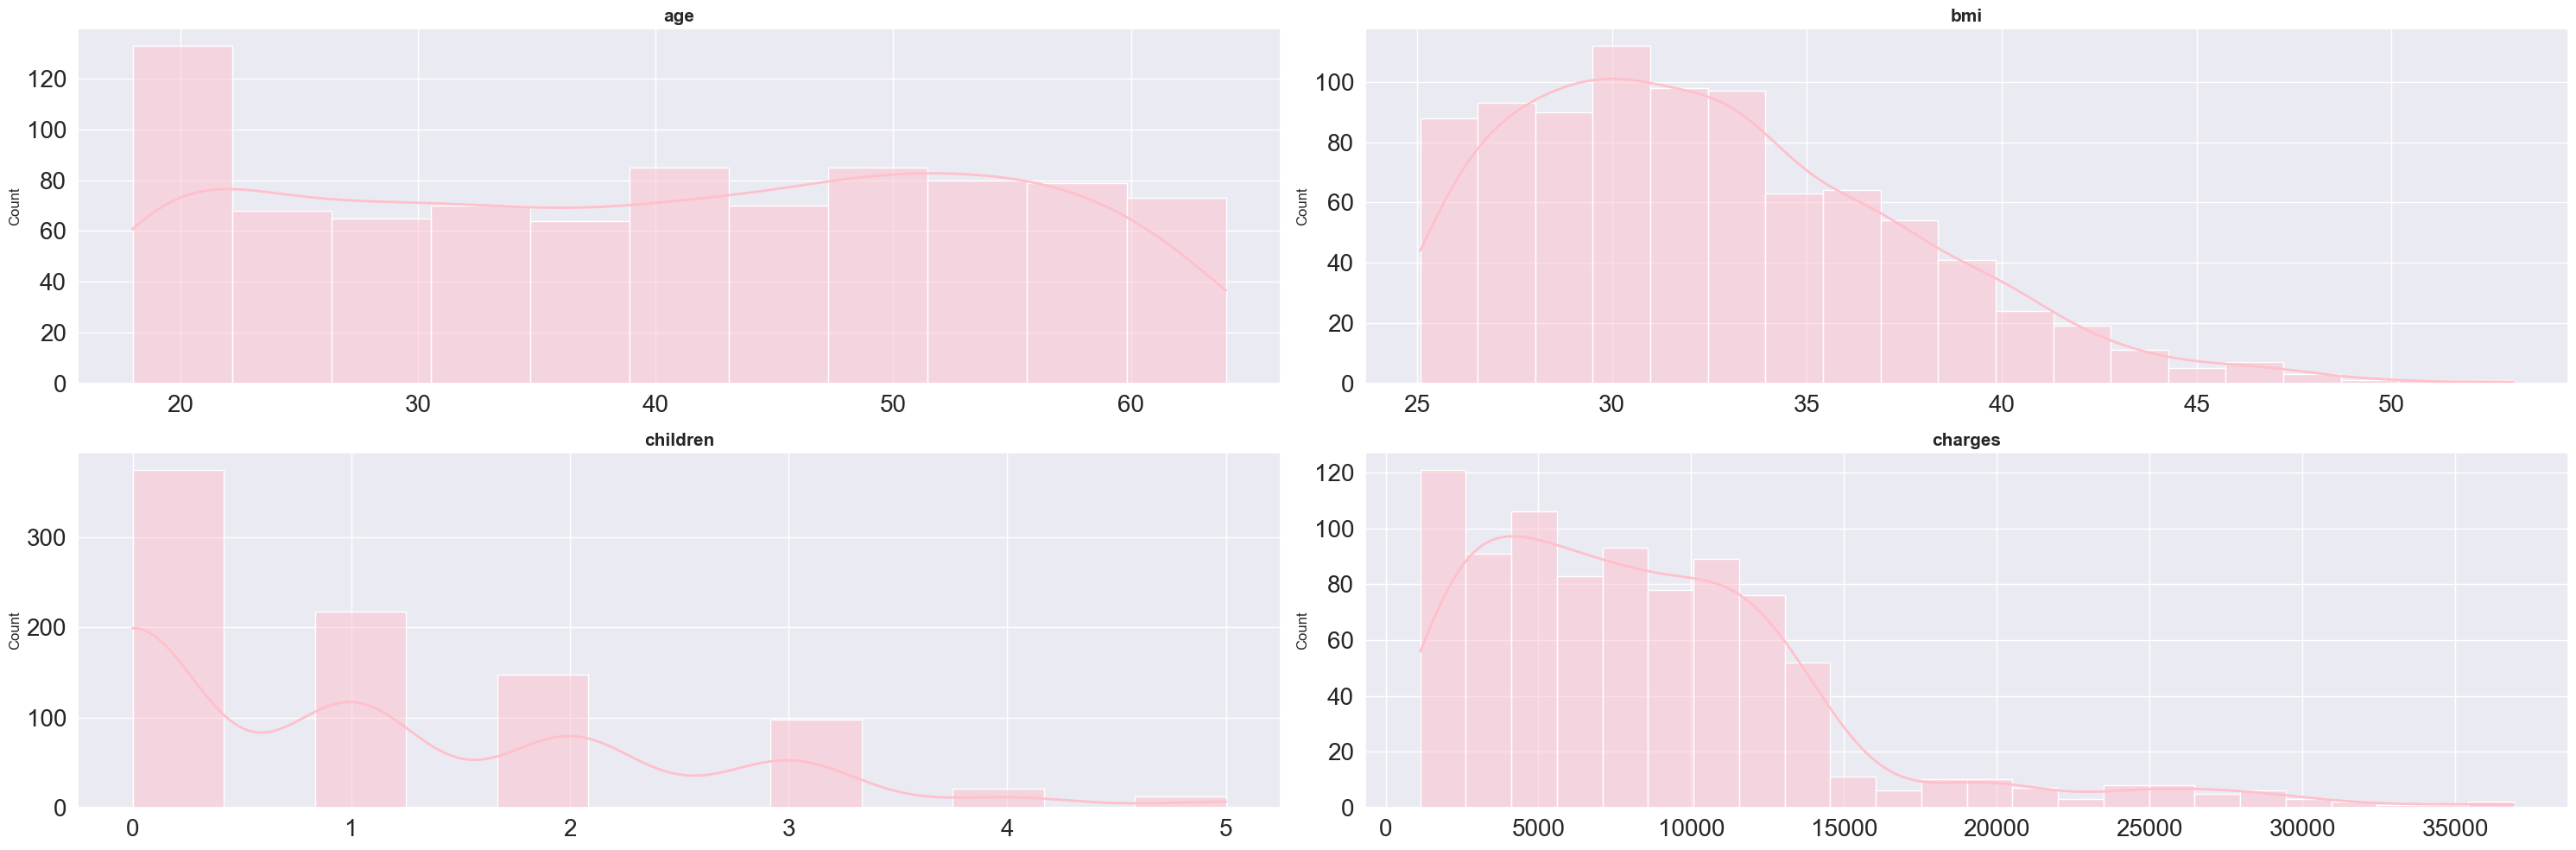

In [281]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (30, 10))
axes = axes.flat#iterador
for i, colum in enumerate(numericas_nfum_no_saludables.columns): 
    sns.histplot(
        data = numericas_nfum_no_saludables[colum],
        kde = True,
        color = "pink", 
        line_kws = {"linewidth": 2}, 
        alpha = 0.5, 
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

In [282]:
shapiro_test = stats.shapiro(numericas_nfum_no_saludables.age)
print(f"Variable age: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_nfum_no_saludables.bmi)
print(f"Variable bmi: {shapiro_test}")
shapiro_test = stats.shapiro(numericas_nfum_no_saludables.charges)
print(f"Variable charges: {shapiro_test}")

Variable age: ShapiroResult(statistic=0.9454286694526672, pvalue=2.110251562675061e-17)
Variable bmi: ShapiroResult(statistic=0.9558265805244446, pvalue=1.5592019439214814e-15)
Variable charges: ShapiroResult(statistic=0.8753319978713989, pvalue=8.058062537627413e-26)


In [283]:
k2, p_value = stats.normaltest(numericas_nfum_saludables.age)
print(f"Variable age: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_nfum_saludables.bmi)
print(f"Variable bmi: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(numericas_nfum_saludables.charges)
print(f"Variable charges: Estadítico = {k2}, p-value = {p_value}")

Variable age: Estadítico = 76.31761999368219, p-value = 2.6781776558126344e-17
Variable bmi: Estadítico = 19.34205325220759, p-value = 6.308505731153563e-05
Variable charges: Estadítico = 64.16748735542456, p-value = 1.1646814593789961e-14


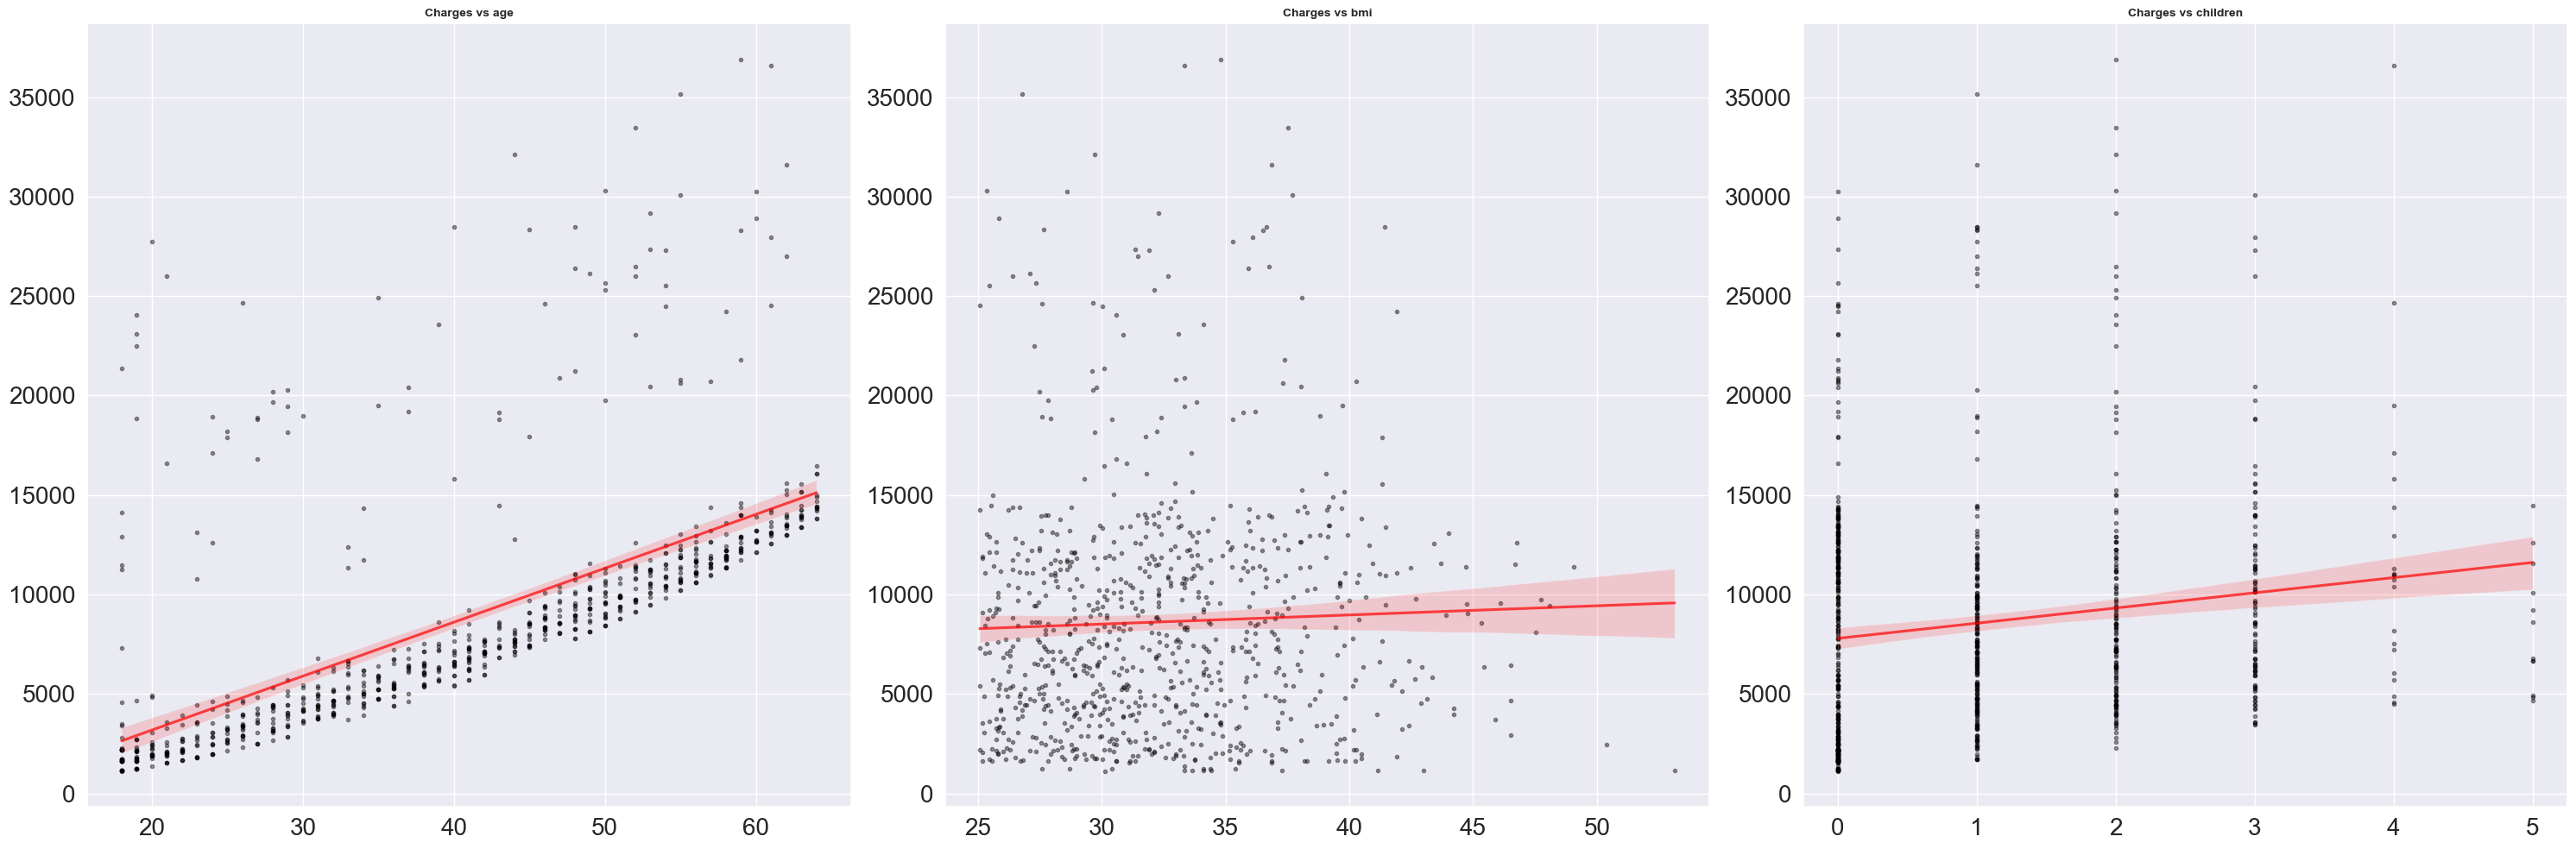

In [284]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))
axes = axes.flat
numericas = numericas_nfum_no_saludables.drop("charges", axis=1) 

for i, colum in enumerate(numericas):
    sns.regplot(
        x = dfnfum_no_saludable[colum], 
        y = dfnfum_no_saludable["charges"], 
        color = "black", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])  
    axes[i].set_title(f"Charges vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")   
fig.tight_layout();

In [285]:
dfnfum_no_saludable.corr(method = 'spearman')#are not normally distributed

age       bmi  children   charges
age       1.000000  0.071032  0.045589  0.818896
bmi       0.071032  1.000000  0.013765  0.064321
children  0.045589  0.013765  1.000000  0.183151
charges   0.818896  0.064321  0.183151  1.000000

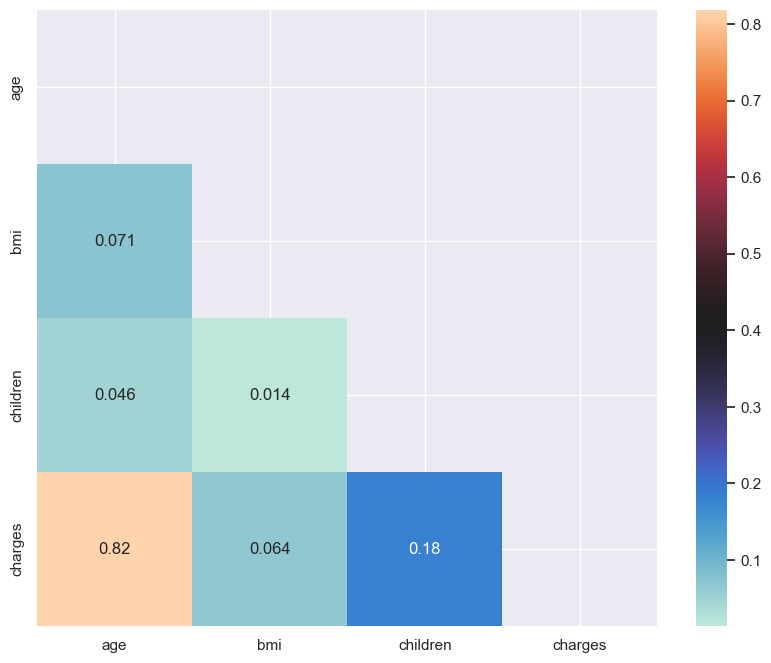

In [286]:
mask = np.triu(np.ones_like(dfnfum_no_saludable.corr(method = 'spearman'), dtype = np.bool))
sns.heatmap(dfnfum_no_saludable.corr(method = 'spearman'), 
           cmap = "icefire", 
            mask = mask,
           annot = True);

In [287]:
display(pg.corr(dfnfum_no_saludable['bmi'], dfnfum_no_saludable['charges'], method='pearson'))
display(pg.corr(dfnfum_no_saludable['bmi'], dfnfum_no_saludable['charges'], method='spearman'))
display(pg.corr(dfnfum_no_saludable['bmi'], dfnfum_no_saludable['charges'], method='kendall'))

n        r         CI95%     p-val   BF10     power
pearson  872  0.03767  [-0.03, 0.1]  0.266495  0.079  0.199144

n         r         CI95%     p-val    power
spearman  872  0.064321  [-0.0, 0.13]  0.057616  0.47601

n         r          CI95%     p-val     power
kendall  872  0.043447  [-0.02, 0.11]  0.055106  0.249539

  We start from population data with overweight problems, including less than 25% of the records with BMIs below 25. 
        Analysing the policies corresponding to healthy BMIs, they are included in more than 75% of the cases within low premiums, whether smokers or not. We have two dataframes resulting from the two humps of 'charges', the low premiums more related to age, and the high premiums more related to smoking habits.

>Based on the sample, economically, they are similar for the company, but with very different n's,
 >We opted to stay with the low premiums, with a higher n, 
 >and relate two numerical variables, age and premium. Since the pair time is limited.


Graphically, we can clearly see that high premiums are more related to smoking habits and high ages, and low premiums have hardly any >representation of this group.

> Calculating average premiums and number of records, the economic impact of both groups into which we have divided the sample is quite similar.